# Momentum on stocks

In [42]:
import os, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import yfinance as yf
from pandas_datareader import data as pdr
from datetime import datetime,timedelta
from yahoo_fin import options
yf.pdr_override()

In [43]:
import warnings
warnings.filterwarnings('ignore')

In [44]:
# Length in Business Days
def get_momentum(ts, lag=260, smooth_lag=3):
    smooth = _get_smooth(ts, smooth_lag)
    res = np.empty(ts.shape)*np.nan
    res[smooth_lag+lag-1:] = smooth[smooth_lag+lag-1:] / smooth[smooth_lag:-lag+1]-1
    return res

In [45]:
def _get_smooth(ts, smooth_lag):
    smooth = ts

    if smooth_lag > 1:
        smooth = np.cumsum(ts, dtype=float)
        smooth[smooth_lag:] = smooth[smooth_lag:] - smooth[:-smooth_lag]
        smooth[:] = smooth[:] / smooth_lag
        smooth[:smooth_lag - 1] = np.nan

    return smooth

In [46]:
start = datetime(2014, 1, 1)
end = datetime(2023, 11, 7)

In [53]:
data = pdr.get_data_yahoo('^GDAXI', start, end)
data_nvda =  pdr.get_data_yahoo('NVDA', start, end)
data_ndx =  pdr.get_data_yahoo('^NDX', start, end)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [55]:
def pivotpoints(df):
    df_lastrow=df.loc[df.index[-1]]
    PivotPoint = (df_lastrow['High']+df_lastrow['Low']+df_lastrow['Close'])/3
    Resistance1 = 2*PivotPoint-df_lastrow['Low']
    Support1 = 2*PivotPoint-df_lastrow['High']
    Resistance2 = PivotPoint - Support1 + Resistance1
    Support2 = PivotPoint - (Resistance1-Support1)
    print('PivotPoint is {}, \n Resistance1 is {}, \n Support1 is {},\n Resistance2 is {},\n Support2 is {} \n'.format(PivotPoint,Resistance1,Support1,
                                                                                                                         Resistance2,Support2))
pivotpoints(data)

PivotPoint is 15156.739908854166, 
 Resistance1 is 15202.639973958332, 
 Support1 is 15090.069661458332,
 Resistance2 is 15269.310221354166,
 Support2 is 15044.169596354166 



In [57]:
data = data[['Close']]

endDate = datetime.today()
data.loc[endDate] = [15200]

data_ndx = data_ndx[['Close']]

data_ndx.loc[endDate] = [15150]

In [58]:
data

,Close
Date,
2014-01-02 00:00:00.000000,9400.040039
2014-01-03 00:00:00.000000,9435.150391
2014-01-06 00:00:00.000000,9428.000000
2014-01-07 00:00:00.000000,9506.200195
2014-01-08 00:00:00.000000,9497.839844
...,...
2023-11-01 00:00:00.000000,14923.269531
2023-11-02 00:00:00.000000,15143.599609
2023-11-03 00:00:00.000000,15189.250000


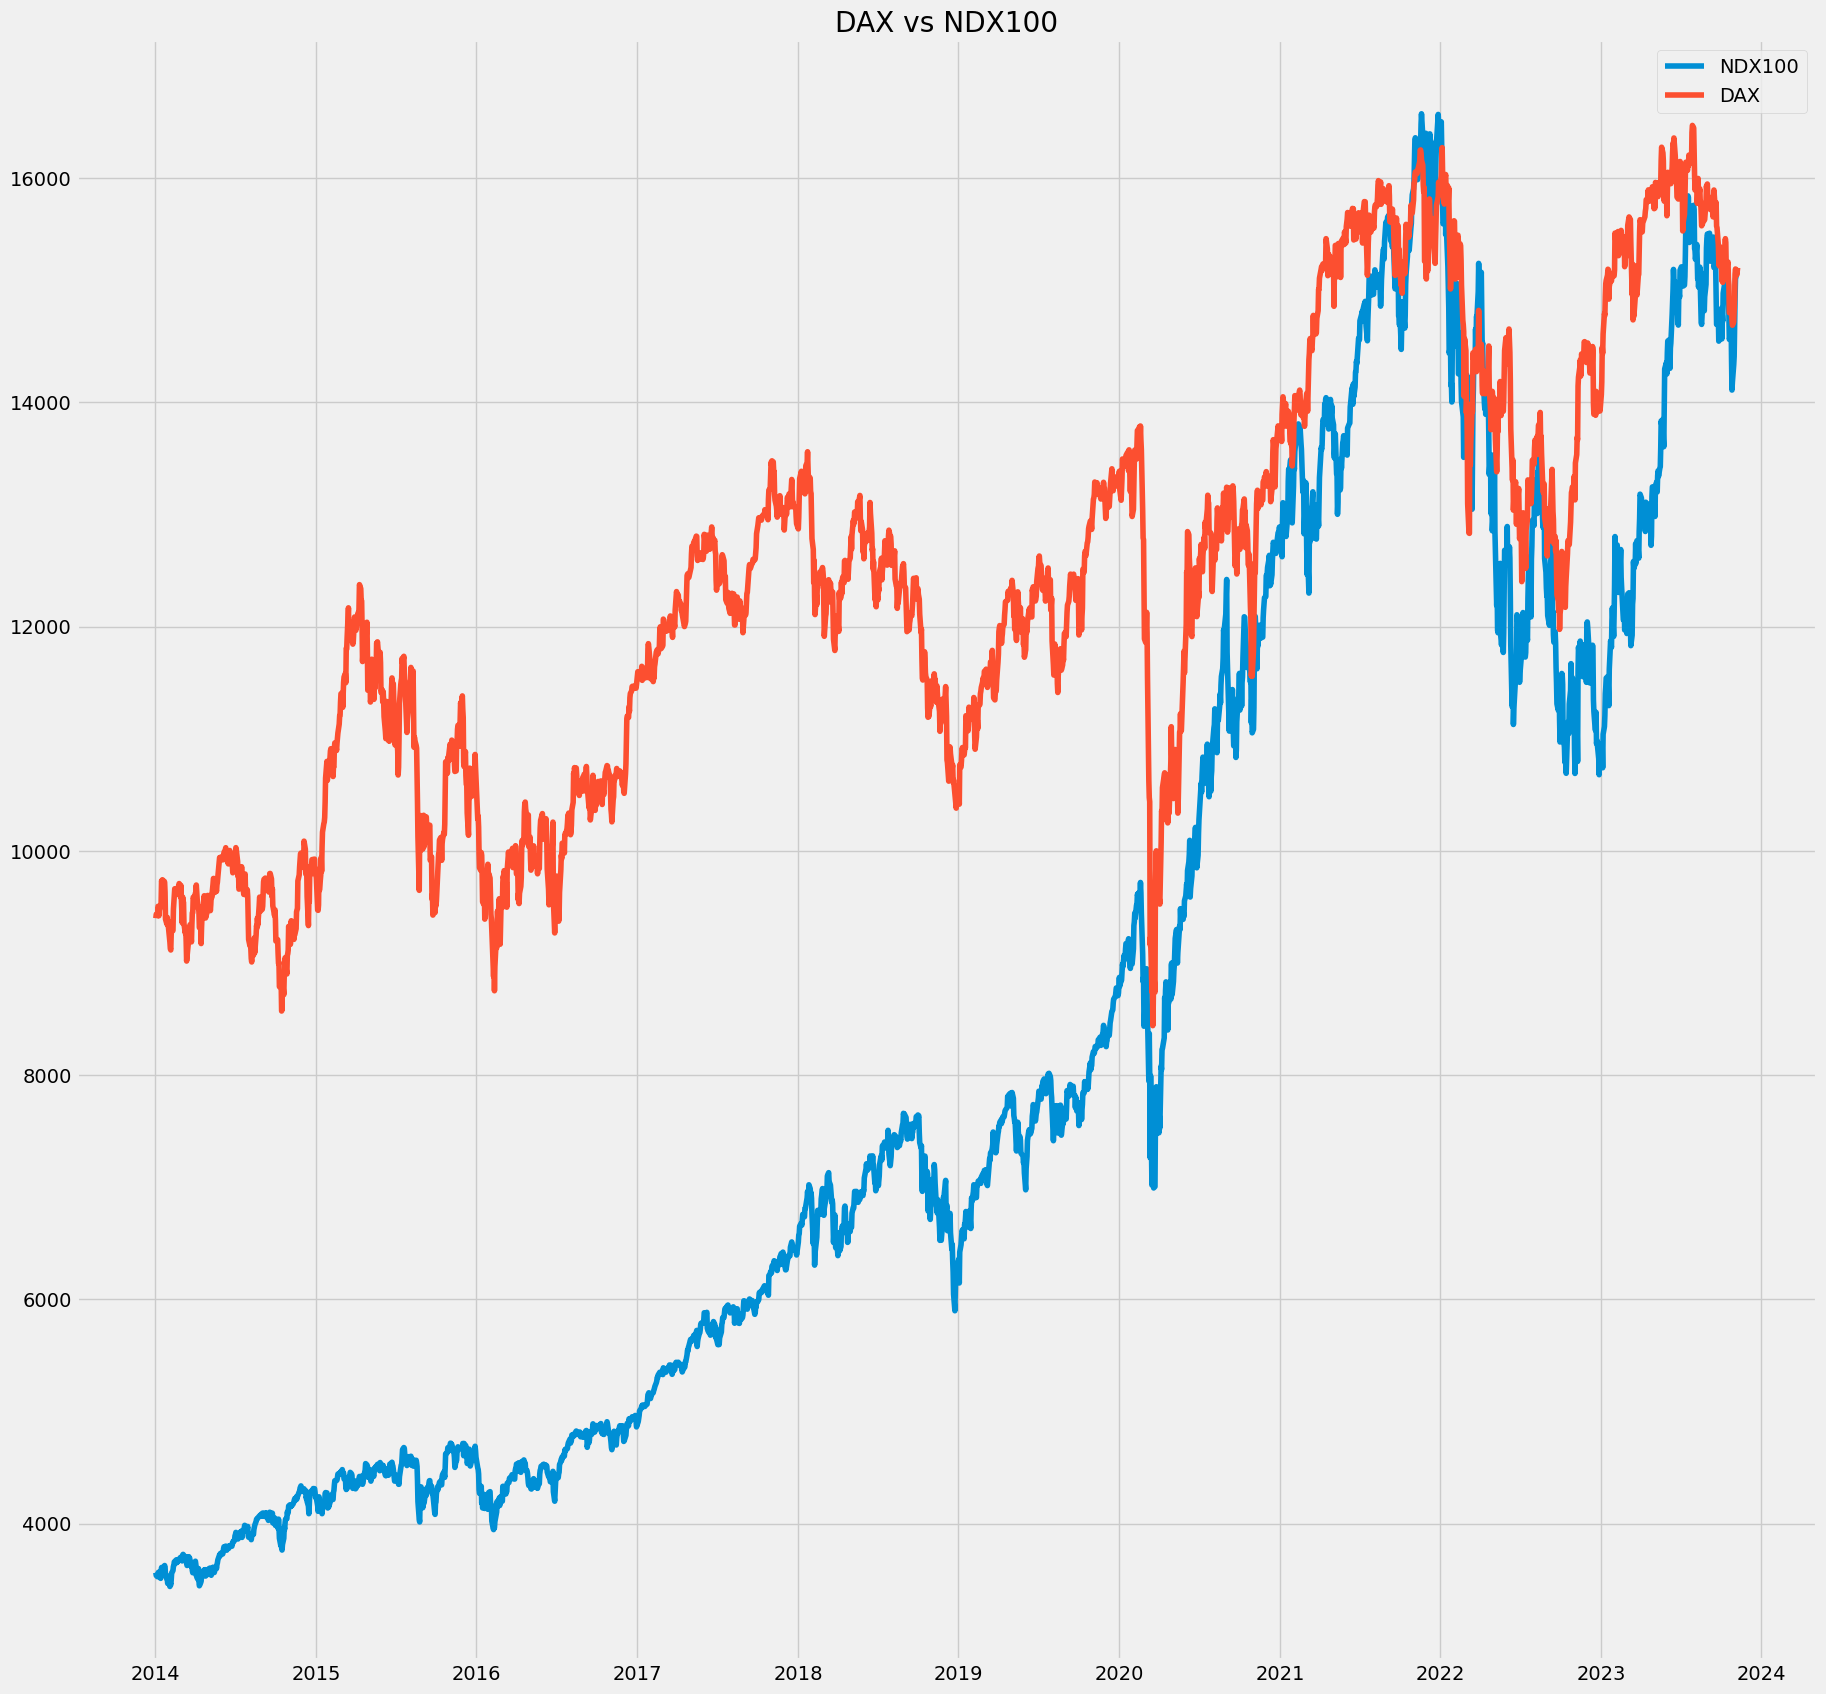

In [59]:
plt.plot(data_ndx)
plt.plot(data)
plt.legend(["NDX100", "DAX"])
plt.title("DAX vs NDX100")
plt.show()

In [60]:
mom_lag = 3  # business days before end of month

categories_lag_months = [9, 3]
smoothing_intervals = 3

In [61]:
# CAT MOMENTUM
def compute_mom(data, categories_lag_months):
    data_mom = None
    for mom_len in categories_lag_months:
        m = data.apply(get_momentum, axis=0, raw=True,
                   args=(mom_len * 22, smoothing_intervals)) * 12 / mom_len / len(categories_lag_months)
    data_mom = m if data_mom is None else data_mom + m
    data_mom = data_mom.dropna()
    return data_mom

data_mom = compute_mom(data, categories_lag_months)

In [62]:
data_mom.tail(10)

,Close
Date,
2023-10-25 00:00:00.000000,0.331232
2023-10-26 00:00:00.000000,0.316078
2023-10-27 00:00:00.000000,0.289050
2023-10-30 00:00:00.000000,0.252923
2023-10-31 00:00:00.000000,0.240968
2023-11-01 00:00:00.000000,0.242105
2023-11-02 00:00:00.000000,0.260344
2023-11-03 00:00:00.000000,0.272132
2023-11-06 00:00:00.000000,0.282043


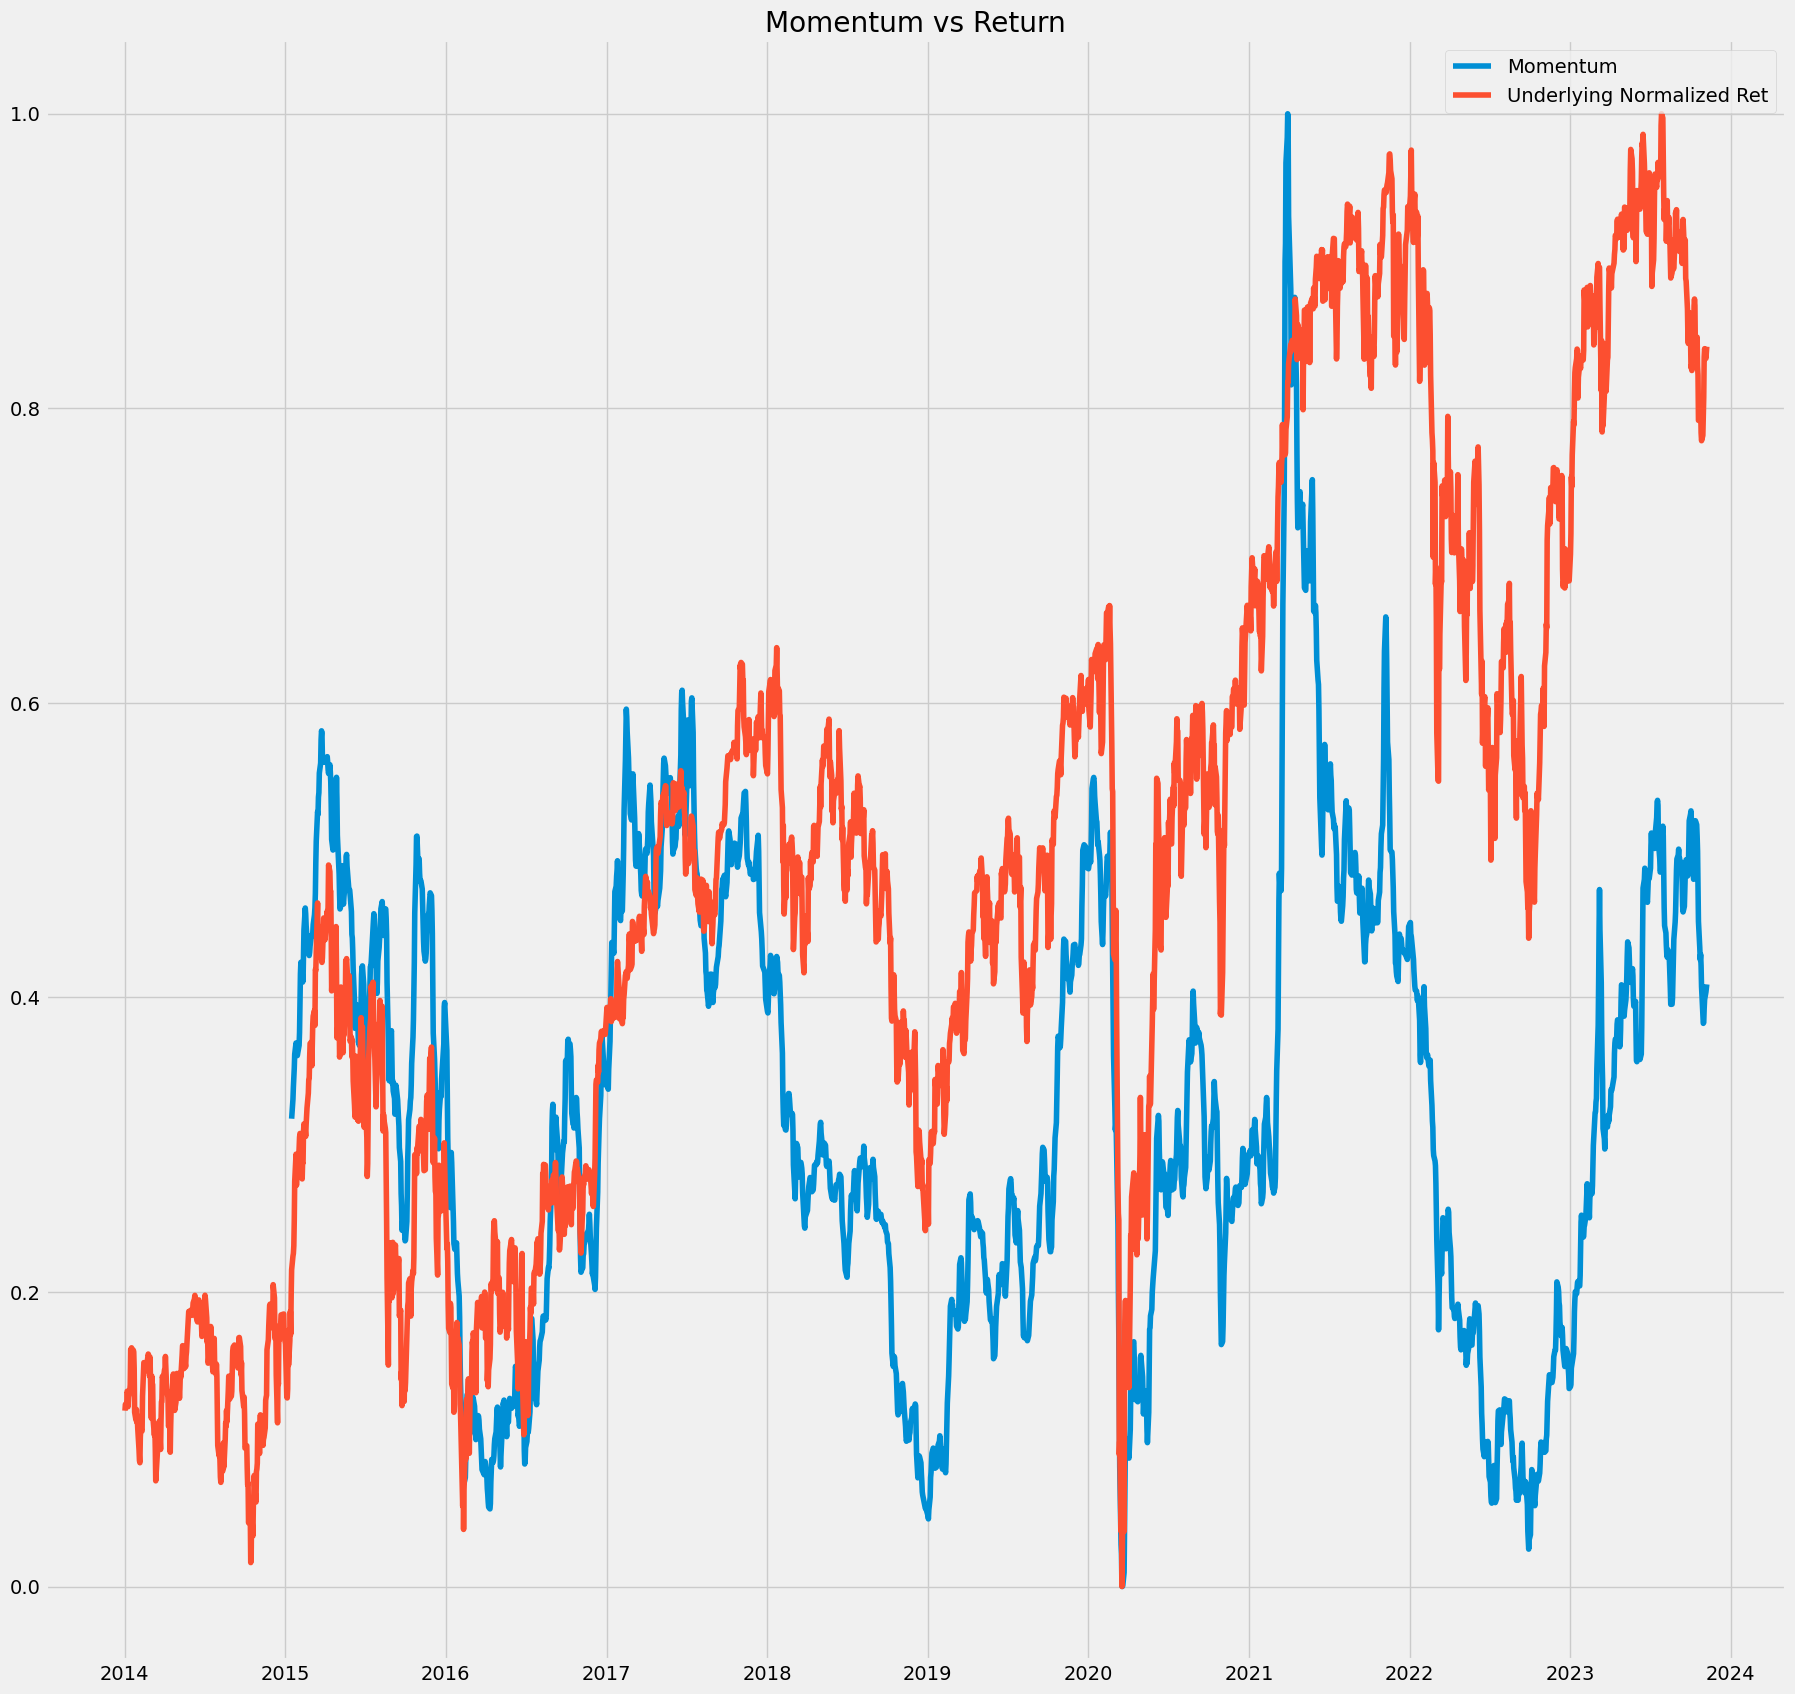

In [63]:
data_mom[["Close_norm"]] = (data_mom[["Close"]] - (data_mom[["Close"]]).min()) / ((data_mom[["Close"]]).max() - (data_mom[["Close"]]).min())
data[["Close_norm"]] = (data[["Close"]] - (data[["Close"]]).min()) / ((data[["Close"]]).max() - (data[["Close"]]).min())


plt.plot(data_mom[["Close_norm"]])
plt.plot((data[["Close_norm"]]))
plt.legend(["Momentum","Underlying Normalized Ret"])
plt.title("Momentum vs Return")
plt.show()

In [64]:
data_ndx.tail()

,Close
Date,
2023-11-01 00:00:00.000000,14664.910156
2023-11-02 00:00:00.000000,14919.549805
2023-11-03 00:00:00.000000,15099.490234
2023-11-06 00:00:00.000000,15154.929688
2023-11-07 21:45:58.105640,15150.000000


In [65]:
data_mom_ndx = compute_mom(data_ndx, categories_lag_months)

In [66]:
data_mom_ndx.tail(10)

,Close
Date,
2023-10-25 00:00:00.000000,0.682098
2023-10-26 00:00:00.000000,0.659821
2023-10-27 00:00:00.000000,0.602867
2023-10-30 00:00:00.000000,0.591032
2023-10-31 00:00:00.000000,0.577064
2023-11-01 00:00:00.000000,0.607389
2023-11-02 00:00:00.000000,0.629629
2023-11-03 00:00:00.000000,0.645015
2023-11-06 00:00:00.000000,0.625586


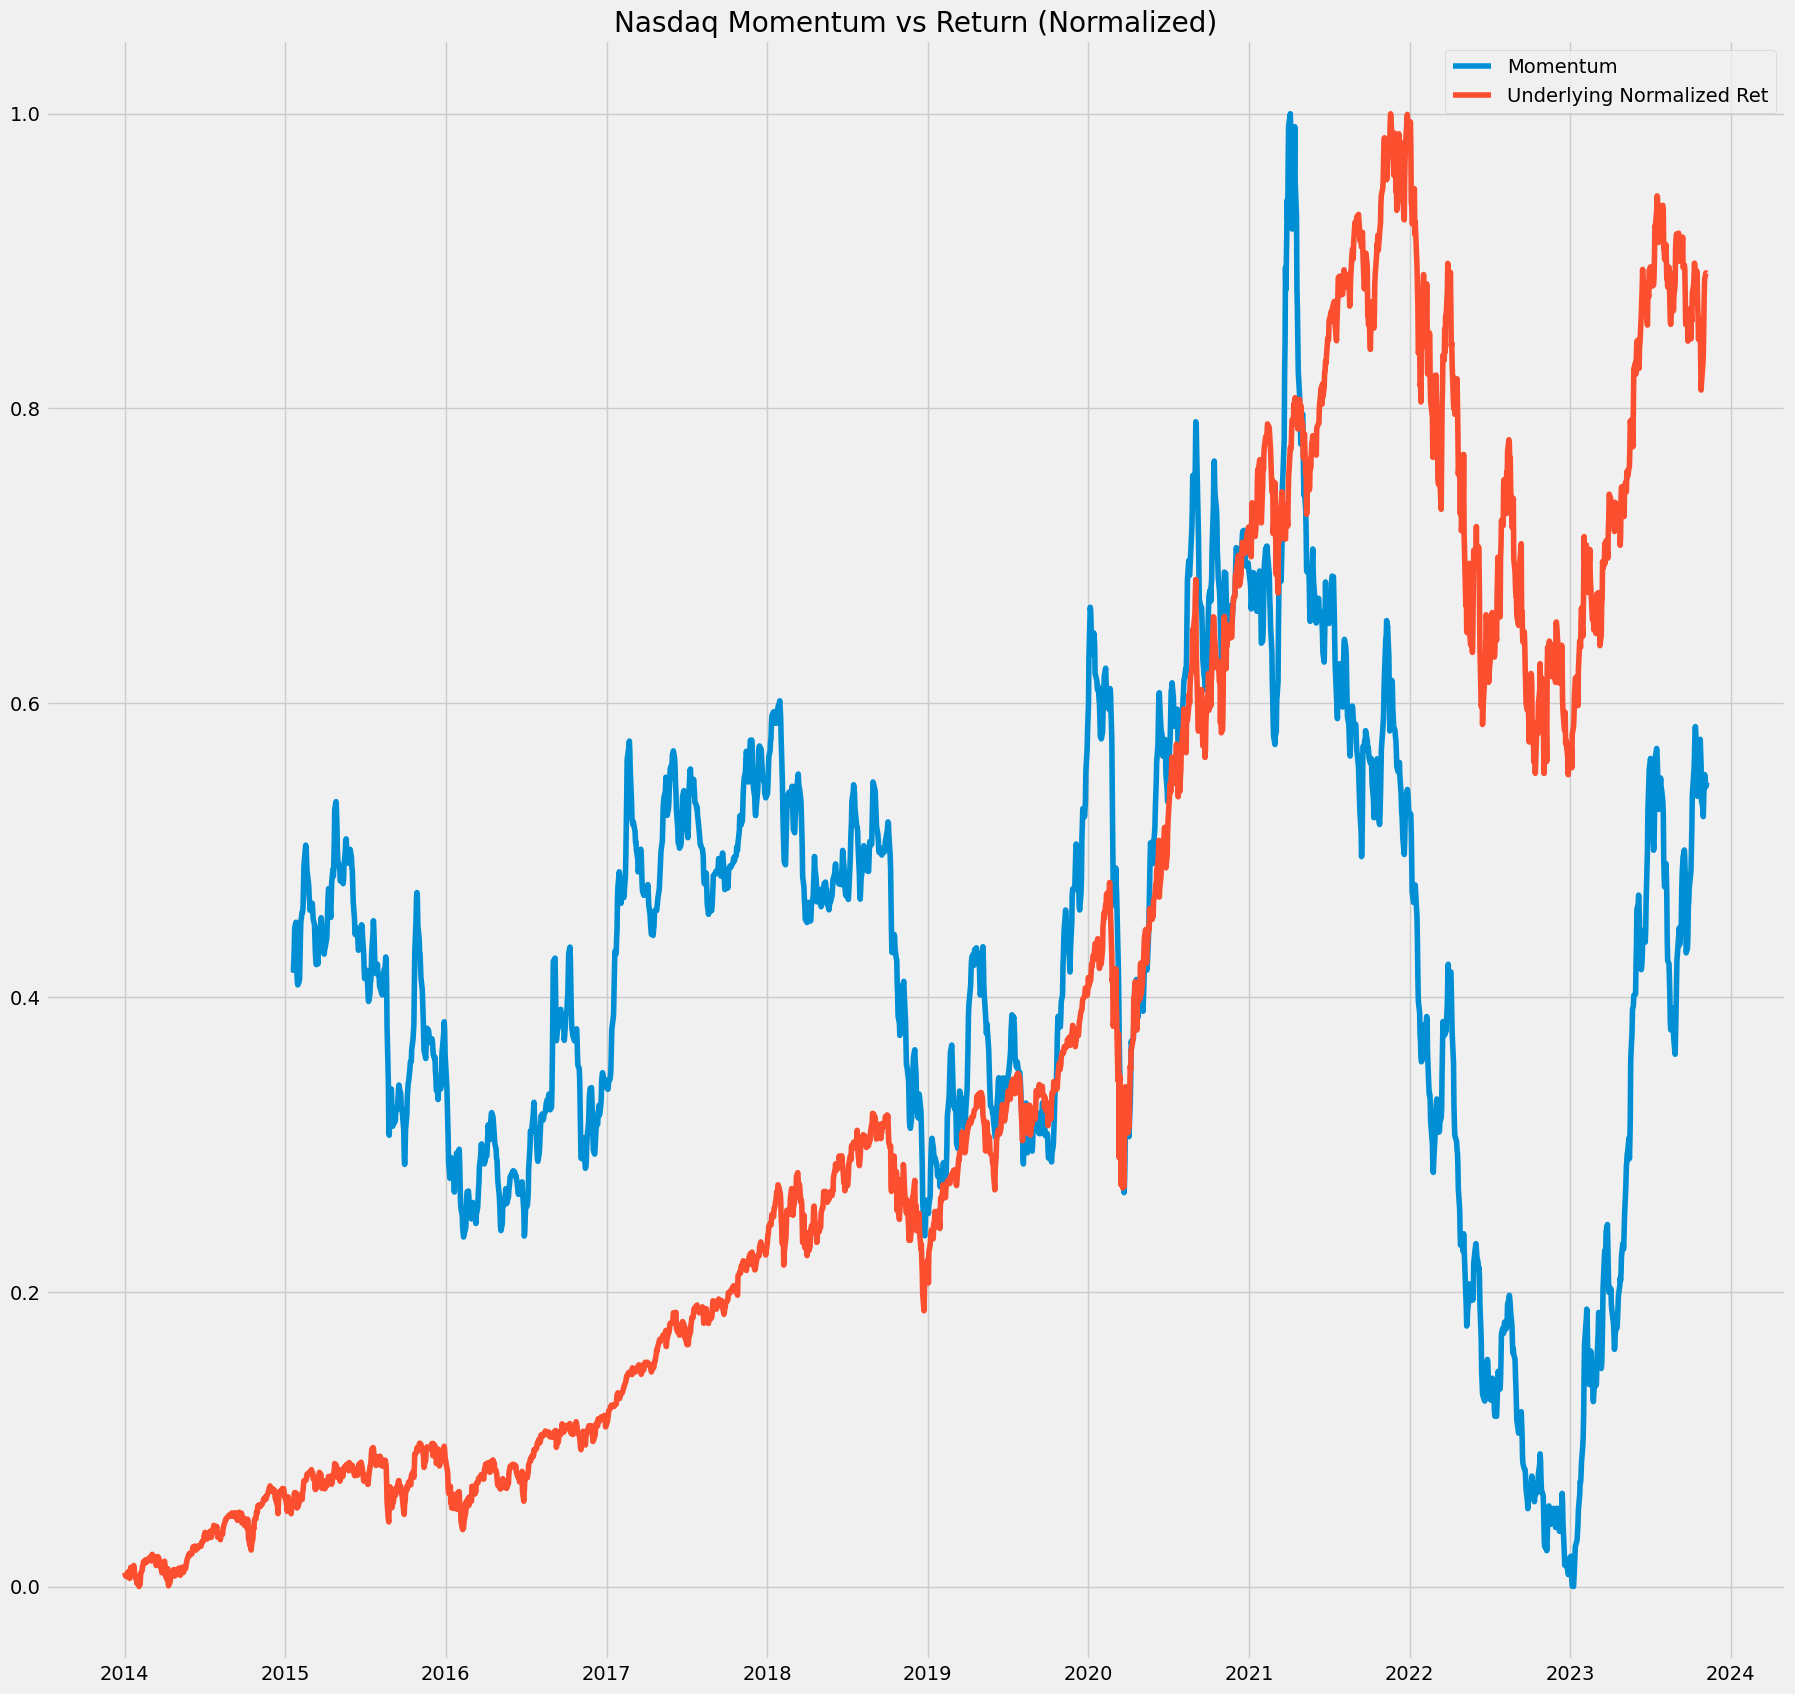

In [67]:
data_mom_ndx[["Close_norm"]] = (data_mom_ndx[["Close"]] - (data_mom_ndx[["Close"]]).min()) / ((data_mom_ndx[["Close"]]).max() - (data_mom_ndx[["Close"]]).min())
data_ndx[["Close_norm"]] = (data_ndx[["Close"]] - (data_ndx[["Close"]]).min()) / ((data_ndx[["Close"]]).max() - (data_ndx[["Close"]]).min())


plt.plot(data_mom_ndx[["Close_norm"]])
plt.plot((data_ndx[["Close_norm"]]))
plt.legend(["Momentum","Underlying Normalized Ret"])
plt.title("Nasdaq Momentum vs Return (Normalized)")
plt.show()

In [16]:
data_mom_nvda = compute_mom(data_nvda, categories_lag_months)

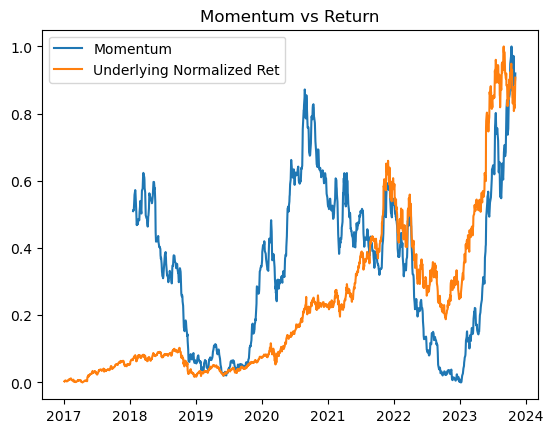

In [17]:
data_mom_nvda[["Close_norm"]] = (data_mom_nvda[["Close"]] - (data_mom_nvda[["Close"]]).min()) / ((data_mom_nvda[["Close"]]).max() - (data_mom_nvda[["Close"]]).min())
data_nvda[["Close_norm"]] = (data_nvda[["Close"]] - (data_nvda[["Close"]]).min()) / ((data_nvda[["Close"]]).max() - (data_nvda[["Close"]]).min())


plt.plot(data_mom_nvda[["Close_norm"]])
plt.plot((data_nvda[["Close_norm"]]))
plt.legend(["Momentum","Underlying Normalized Ret"])
plt.title("Momentum vs Return")
plt.show()

In [18]:
data_mom_nvda.tail(10)

,Open,High,Low,Close,Adj Close,Volume,Close_norm
Date,,,,,,,
2023-10-23,4.976151,5.042304,5.138824,5.158553,5.162932,-0.571469,0.940277
2023-10-24,5.174915,5.249125,5.328358,5.367073,5.371580,-0.540569,0.971986
2023-10-25,5.487555,5.324659,5.487276,5.328483,5.332965,-0.728099,0.966117
2023-10-26,5.416303,5.215399,5.441161,5.251593,5.256029,-0.695757,0.954425
2023-10-27,5.316679,5.035006,5.243395,4.991020,4.995295,-0.735104,0.914801
2023-10-30,4.908321,4.852234,5.011037,4.954393,4.958646,-0.622200,0.909232
2023-10-31,4.864217,4.732862,4.847551,4.820086,4.824257,-0.499625,0.888809
2023-11-01,4.738276,4.648374,4.782349,4.863250,4.867448,-0.535510,0.895372
2023-11-02,4.908396,4.759922,4.866131,4.897714,4.901934,-0.470906,0.900613


# Causality (Pairs Trading)

In [19]:
start=datetime(2021, 1, 1)

In [59]:
start

datetime.datetime(2021, 1, 1, 0, 0)

In [60]:
df = pdr.get_data_yahoo(['LE=F', 'NVDA'], start, end)["Adj Close"]

[*********************100%***********************]  2 of 2 completed


In [61]:
df

,LE=F,NVDA
Date,,
2021-01-04,112.300003,130.851624
2021-01-05,115.050003,133.757812
2021-01-06,115.000000,125.872391
2021-01-07,114.974998,133.151627
2021-01-08,114.474998,132.480576
...,...,...
2023-09-08,183.225006,455.720001
2023-09-11,184.225006,451.779999
2023-09-12,184.149994,448.700012


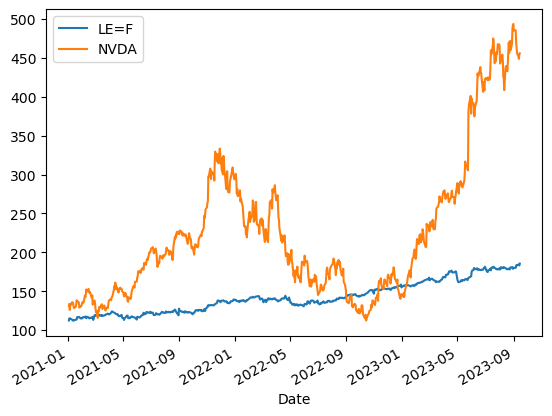

In [24]:
df["2021-01-01":"2023-09-15"].plot();

In [33]:
def feature_normalize(dataset):
    mu = np.mean(dataset,axis = 0)
    sigma = np.std(dataset,axis = 0)
    return (dataset - mu)/sigma

<Axes: xlabel='LE=F', ylabel='NVDA'>

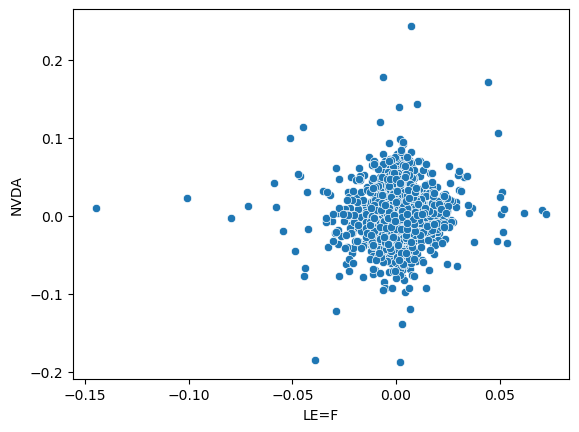

In [69]:
sns.scatterplot(x=df_ret['LE=F'],y=df_ret['NVDA'])  

In [68]:
df_ret

,LE=F,NVDA
Date,,
2017-01-03,NaN,NaN
2017-01-04,0.006964,0.023331
2017-01-05,-0.005187,-0.025386
2017-01-06,-0.002172,0.013368
2017-01-09,0.014805,0.040543
...,...,...
2023-09-08,-0.002314,-0.014468
2023-09-11,0.005458,-0.008646
2023-09-12,-0.000407,-0.006817


In [34]:
df_norm = feature_normalize(df)

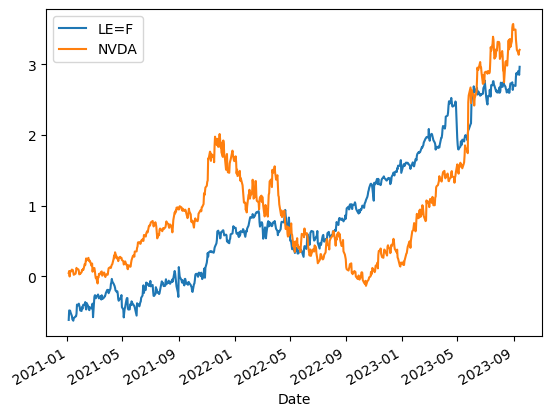

In [35]:
df_norm["2021-01-01":"2023-09-15"].plot();

In [45]:
df_norm.sample

<bound method NDFrame.sample of                 LE=F      NVDA
Date                          
2017-01-03 -0.492437 -0.982452
2017-01-04 -0.453281 -0.976753
2017-01-05 -0.482648 -0.983099
2017-01-06 -0.494884 -0.979842
2017-01-09 -0.411678 -0.969832
...              ...       ...
2023-09-08  2.852928  3.202004
2023-09-11  2.901873  3.163714
2023-09-12  2.898201  3.133782
2023-09-13  2.849256  3.193549
2023-09-14  2.963053  3.202878

[1686 rows x 2 columns]>

In [49]:
df_norm

,LE=F,NVDA
Date,,
2017-01-03,-0.492437,-0.982452
2017-01-04,-0.453281,-0.976753
2017-01-05,-0.482648,-0.983099
2017-01-06,-0.494884,-0.979842
2017-01-09,-0.411678,-0.969832
...,...,...
2023-09-08,2.852928,3.202004
2023-09-11,2.901873,3.163714
2023-09-12,2.898201,3.133782


In [47]:
from statsmodels.tsa.stattools import grangercausalitytests

In [48]:
# Perform the Granger causality test
max_lag = 5  # You can adjust the maximum lag order as needed
test_result = grangercausalitytests(df_norm, max_lag, verbose=True)

# Interpret the results
for lag in range(1, max_lag + 1):
    p_value = test_result[lag][0]['ssr_ftest'][1]
    print(f'Lag {lag}: p-value = {p_value:.4f}')


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.1992  , p=0.0129  , df_denom=1682, df_num=1
ssr based chi2 test:   chi2=6.2102  , p=0.0127  , df=1
likelihood ratio test: chi2=6.1988  , p=0.0128  , df=1
parameter F test:         F=6.1992  , p=0.0129  , df_denom=1682, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.2327  , p=0.0397  , df_denom=1679, df_num=2
ssr based chi2 test:   chi2=6.4847  , p=0.0391  , df=2
likelihood ratio test: chi2=6.4722  , p=0.0393  , df=2
parameter F test:         F=3.2327  , p=0.0397  , df_denom=1679, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.1200  , p=0.0958  , df_denom=1676, df_num=3
ssr based chi2 test:   chi2=6.3866  , p=0.0942  , df=3
likelihood ratio test: chi2=6.3745  , p=0.0947  , df=3
parameter F test:         F=2.1200  , p=0.0958  , df_denom=1676, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.9404  , p=0.

In [50]:
# Swap the order of the columns to test if 'NVDA' Granger causes 'LE=F'
df_new = df_norm[['NVDA', 'LE=F']]

# Perform the Granger causality test
max_lag = 5  # You can adjust the maximum lag order as needed
test_result = grangercausalitytests(df_new, max_lag, verbose=True)

# Interpret the results
for lag in range(1, max_lag + 1):
    p_value = test_result[lag][0]['ssr_ftest'][1]
    print(f'Lag {lag}: p-value = {p_value:.4f}')


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.8648  , p=0.0907  , df_denom=1682, df_num=1
ssr based chi2 test:   chi2=2.8699  , p=0.0902  , df=1
likelihood ratio test: chi2=2.8675  , p=0.0904  , df=1
parameter F test:         F=2.8648  , p=0.0907  , df_denom=1682, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.9414  , p=0.1438  , df_denom=1679, df_num=2
ssr based chi2 test:   chi2=3.8944  , p=0.1427  , df=2
likelihood ratio test: chi2=3.8899  , p=0.1430  , df=2
parameter F test:         F=1.9414  , p=0.1438  , df_denom=1679, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.6902  , p=0.1671  , df_denom=1676, df_num=3
ssr based chi2 test:   chi2=5.0919  , p=0.1652  , df=3
likelihood ratio test: chi2=5.0842  , p=0.1657  , df=3
parameter F test:         F=1.6902  , p=0.1671  , df_denom=1676, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.2711  , p=0.

In [38]:
from sklearn.preprocessing import MinMaxScaler

In [39]:
#computing fuel spread after scaling and then adding to carbon df
scaler = MinMaxScaler()

# Scaling the columns
scaled_columns = scaler.fit_transform(df)

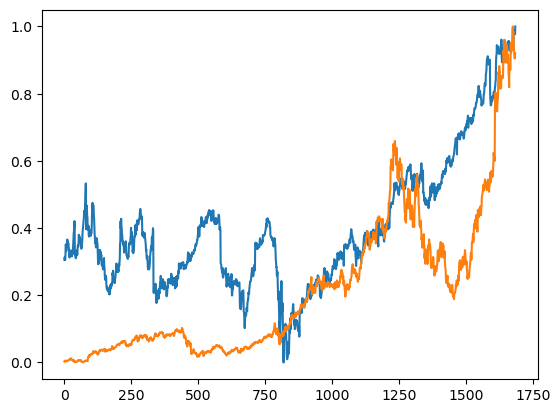

In [43]:
plt.plot(scaled_columns);

In [27]:
((df_ret.mean() + 1).pow(365) - 1) * 100

LE=F     14.191716
NVDA    125.185053
dtype: float64

In [62]:
correlation_matrix = df.corr()

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
df_ret = df.pct_change()

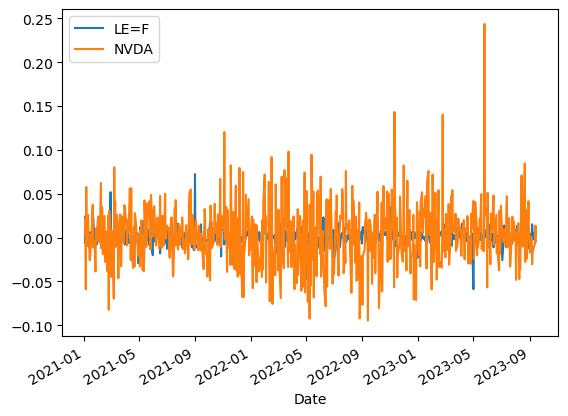

In [26]:
df_ret["2021-01-01":"2023-09-15"].plot();

# Put-Call Open Interest/Volume

In [7]:
def options_chain(symbol):
    tk = yf.Ticker(symbol)
    # Expiration dates
    exps = tk.options

    # Get options for each expiration
    options = pd.DataFrame()
    for e in exps:
        opt = tk.option_chain(e)
        opt = pd.DataFrame().append(opt.calls).append(opt.puts)
        opt["expirationDate"] = e
        options = options.append(opt, ignore_index=True)

    # Bizarre error in `yfinance` that gives the wrong expiration date
    # Add 1 day to get the correct expiration date
    options["expirationDate"] = pd.to_datetime(
        options["expirationDate"]
    ) + datetime.timedelta(days=1)
    options["dte"] = (
        options["expirationDate"] - datetime.datetime.today()
    ).dt.days / 365

    # Boolean column if the option is a CALL
    options["CALL"] = options["contractSymbol"].str[4:].apply(lambda x: "C" in x)

    # options[['bid', 'ask', 'strike']] = options[['bid', 'ask', 'strike']].apply(pd.to_numeric)
    options[["bid", "ask", "strike", "volume", "Implied Volatility"]] = options[
        ["bid", "ask", "strike", "volume", "Implied Volatility"]
    ].apply(pd.to_numeric)
    options["mark"] = (
        options["bid"] + options["ask"]
    ) / 2  # Calculate the midpoint of the bid-ask

    # Drop unnecessary and meaningless columns
    options = options.drop(
        columns=[
            "contractSize",
            "currency",
            "change",
            "percentChange",
            "lastTradeDate",
            "lastPrice",
        ]
    )

    return options

In [8]:
spy_dates = options.get_expiration_dates("SPY")
len(spy_dates)

29

In [9]:
try:
    callsSpy = options.get_calls("SPY")
except:
    pass

callsSpy["Open Interest"] = (
    callsSpy["Open Interest"].astype(str).str.replace("-", "0").astype(float)
)
list(callsSpy.columns)

['Contract Name',
 'Last Trade Date',
 'Strike',
 'Last Price',
 'Bid',
 'Ask',
 'Change',
 '% Change',
 'Volume',
 'Open Interest',
 'Implied Volatility']

In [10]:
callStrikes = list(callsSpy["Strike"])
callOpenInt = list(callsSpy["Open Interest"])

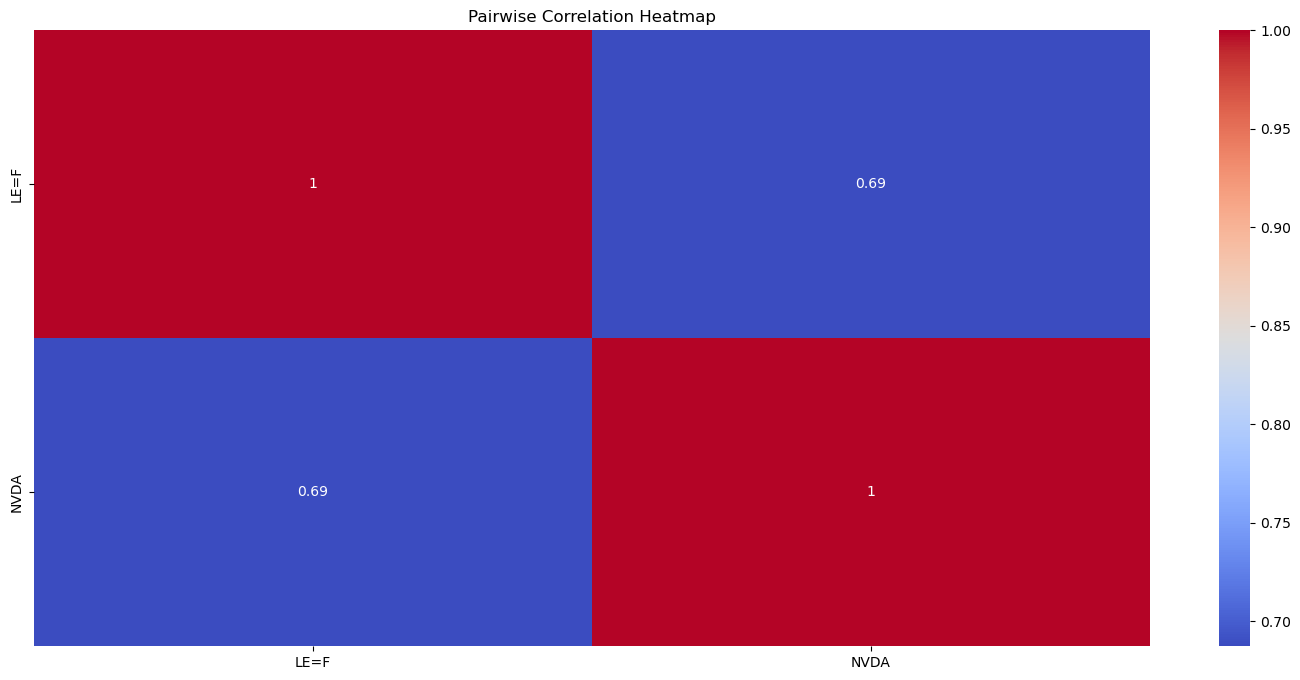

In [63]:
# Create the heatmap
plt.figure(figsize=(18, 8))  # Adjust the figure size as needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

# Set the plot title
plt.title('Pairwise Correlation Heatmap')

# Show the plot
plt.show()

In [11]:
today_date = datetime.now().strftime('%Y-%m-%d')
save_directory = 'C:/BOYAN LAB/Quant Research/Asset Allocation Research/PutCall'

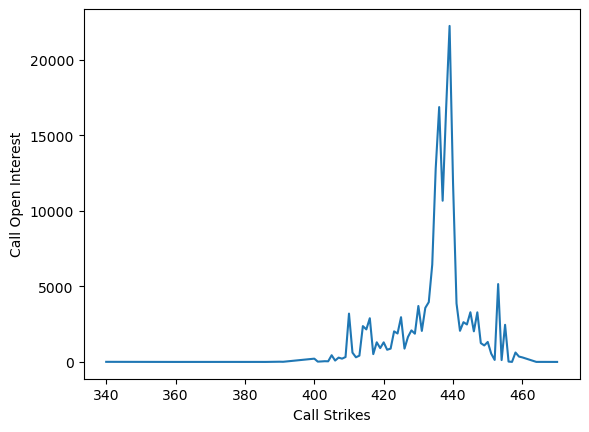

In [12]:
plt.plot(callStrikes, callOpenInt)
plt.xlabel("Call Strikes")
plt.ylabel("Call Open Interest");
full_path = os.path.join(save_directory, f'Call_Open_Interest_{today_date}.png')
plt.savefig(full_path)

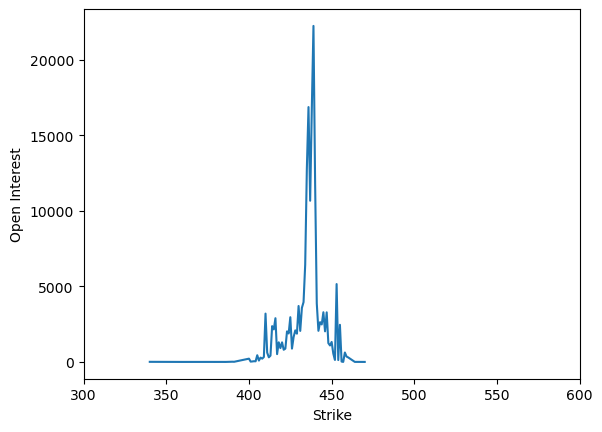

In [13]:
plt.xlim([300, 600])
plt.plot(callStrikes, callOpenInt)
plt.xlabel("Strike")
plt.ylabel("Open Interest");


In [14]:
try:
    putsSpy = options.get_puts("Spy")
except:  # noqa E722
    # to load data from local file in case of any disruptions
    putsSpy = pd.read_csv("Spy_puts.csv")

for index in putsSpy.index:
    if "-" == putsSpy["Volume"][index]:
        putsSpy.loc[index, "Volume"] = 0

putsSpy["Open Interest"] = (
    putsSpy["Open Interest"].astype(str).str.replace("-", "0").astype(float)
)
numPutStrikes = putsSpy["Strike"].count()
numPutStrikes

94

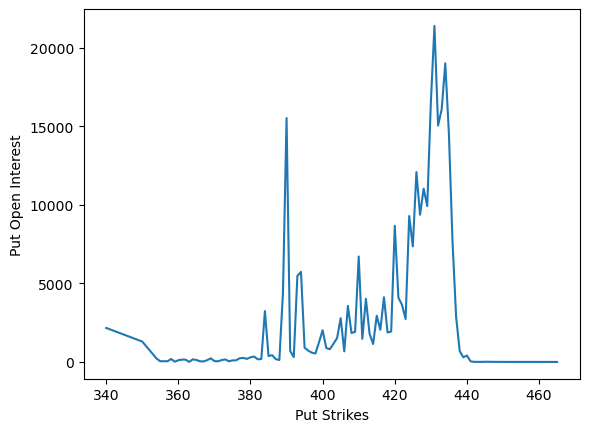

In [15]:
putStrikes = list(putsSpy["Strike"])
putOpenInt = list(putsSpy["Open Interest"])
plt.plot(putStrikes, putOpenInt)
plt.xlabel("Put Strikes")
plt.ylabel("Put Open Interest");
full_path = os.path.join(save_directory, f'Put_Open_Interest_{today_date}.png')
plt.savefig(full_path)

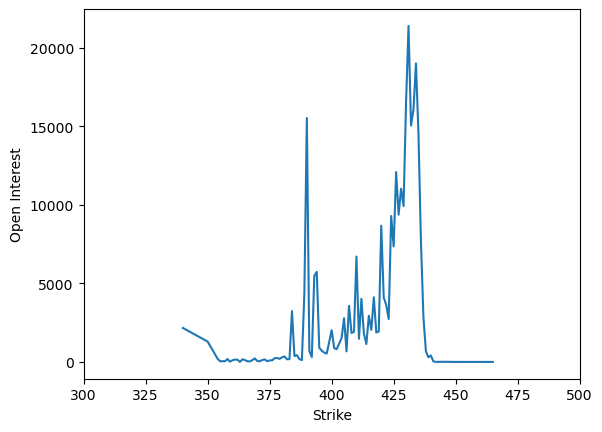

In [16]:
plt.xlim([300, 500])
plt.plot(putStrikes, putOpenInt)
plt.xlabel("Strike")
plt.ylabel("Open Interest");

In [17]:
for index in callsSpy.index:
    if "-" == callsSpy["Volume"][index]:
        callsSpy.loc[index, "Volume"] = 0

In [18]:
callsSpy.Volume = callsSpy.Volume.astype(float)

In [19]:
for index in putsSpy.index:
    if "-" == putsSpy["Volume"][index]:
        putsSpy.loc[index, "Volume"] = 0

putsSpy.Volume = putsSpy.Volume.astype(float)

In [20]:
callVolume = list(callsSpy["Volume"])
putVolume = list(putsSpy["Volume"])

In [21]:
from pytickersymbols import PyTickerSymbols

stock_data = PyTickerSymbols()
countries = stock_data.get_all_countries()
indices = stock_data.get_all_indices()
industries = stock_data.get_all_industries()

In [22]:
callDf = pd.DataFrame()
callDf["Strikes"] = callStrikes
callDf["CallOpenInt"] = callOpenInt
callDf["CallVolume"] = callVolume

putDf = pd.DataFrame()
putDf["Strikes"] = putStrikes
putDf["PutOpenInt"] = putOpenInt
putDf["PutVolume"] = putVolume

In [23]:
df = callDf.merge(putDf)
df = df[(df["Strikes"] > 300) & (df["Strikes"] < 600)]
list(df.dtypes)

[dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64')]

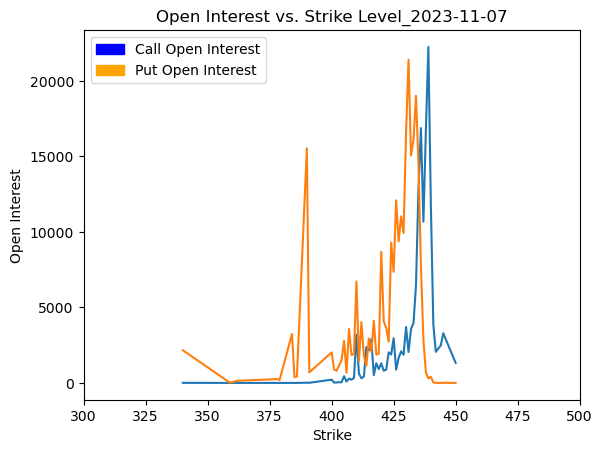

In [24]:
plt.xlim([300, 500])
plt.plot(list(df["Strikes"]), list(df["CallOpenInt"]))
plt.plot(list(df["Strikes"]), list(df["PutOpenInt"]))
plt.title(f'Open Interest vs. Strike Level_{today_date}')
plt.xlabel("Strike")
plt.ylabel("Open Interest")

patch1 = mpatches.Patch(color="blue", label="Call Open Interest")
patch2 = mpatches.Patch(color="orange", label="Put Open Interest")
plt.legend(handles=[patch1, patch2]);
full_path = os.path.join(save_directory, f'PutCall_Open_Interest_{today_date}.png')
plt.savefig(full_path)

In [25]:
def PutCallRatioOpenInterest(df):
    pcroi = sum(df["PutOpenInt"]) / sum(df["CallOpenInt"])
    return round(pcroi, 4)


PutCallRatioOpenInterest(df)

1.6659

In [26]:
def PutCallRatioVolume(df):
    pcv = sum(df["PutVolume"]) / sum(df["CallVolume"])
    return round(pcv, 4)


PutCallRatioVolume(df)

1.0241

In [27]:
# Sample data
data = {'date': ['2023-10-16','2023-10-18','2023-10-19','2023-10-20','2023-10-24','2023-10-25','2023-10-26',
                 '2023-10-27','2023-10-30','2023-10-31','2023-11-01','2023-11-02','2023-11-03','2023-11-06','2023-11-07'],
        'PC_openInt': [1.5433,1.2931,0.9458,1.6473,0.8717,0.7434,0.6113,1.4985,1.1056,1.2554,0.9921,1.3903,2.4081,2.0074,1.6659],
        'PC_volume': [0.9826,1.0414,1.3311,1.3874,0.9112,1.1742,0.9351,1.1089,1.2896,1.355,1.2043,0.986,0.9983,1.179,1.0241]}

# Create a DataFrame
df = pd.DataFrame(data)

# Convert the 'date' column to datetime format and set it as the index
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# Display the DataFrame
print(df)

            PC_openInt  PC_volume
date                             
2023-10-16      1.5433     0.9826
2023-10-18      1.2931     1.0414
2023-10-19      0.9458     1.3311
2023-10-20      1.6473     1.3874
2023-10-24      0.8717     0.9112
2023-10-25      0.7434     1.1742
2023-10-26      0.6113     0.9351
2023-10-27      1.4985     1.1089
2023-10-30      1.1056     1.2896
2023-10-31      1.2554     1.3550
2023-11-01      0.9921     1.2043
2023-11-02      1.3903     0.9860
2023-11-03      2.4081     0.9983
2023-11-06      2.0074     1.1790
2023-11-07      1.6659     1.0241


<Axes: xlabel='date'>

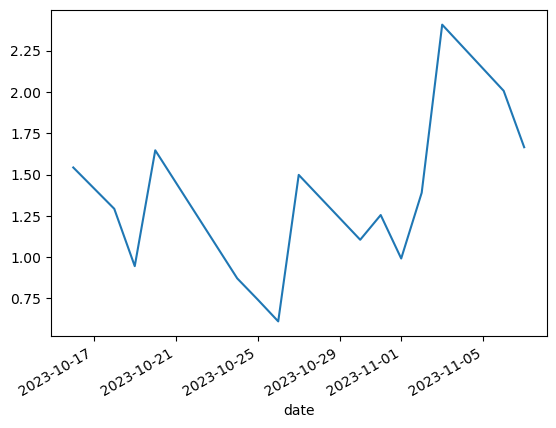

In [28]:
df.PC_openInt.plot()

# Trend Strength

In [33]:
from ta import add_all_ta_features
from ta.utils import dropna
import matplotlib as mpl
from datetime import date

In [36]:
data = pdr.get_data_yahoo('^GDAXI', start, end)
data_ndx =  pdr.get_data_yahoo('^NDX', start, end)
df = data.copy()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [37]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-10-30,14770.950195,14798.000000,14678.730469,14716.540039,14716.540039,76179000
2023-10-31,14741.440430,14829.620117,14722.379883,14810.339844,14810.339844,75370200
2023-11-01,14851.959961,14949.580078,14786.320312,14923.269531,14923.269531,63588700
2023-11-02,15033.650391,15202.429688,15028.030273,15143.599609,15143.599609,89446500
2023-11-03,15203.799805,15269.500000,15149.719727,15189.250000,15189.250000,93603800


## RSI

In [38]:
change = data["Adj Close"].diff()
change.dropna(inplace=True)

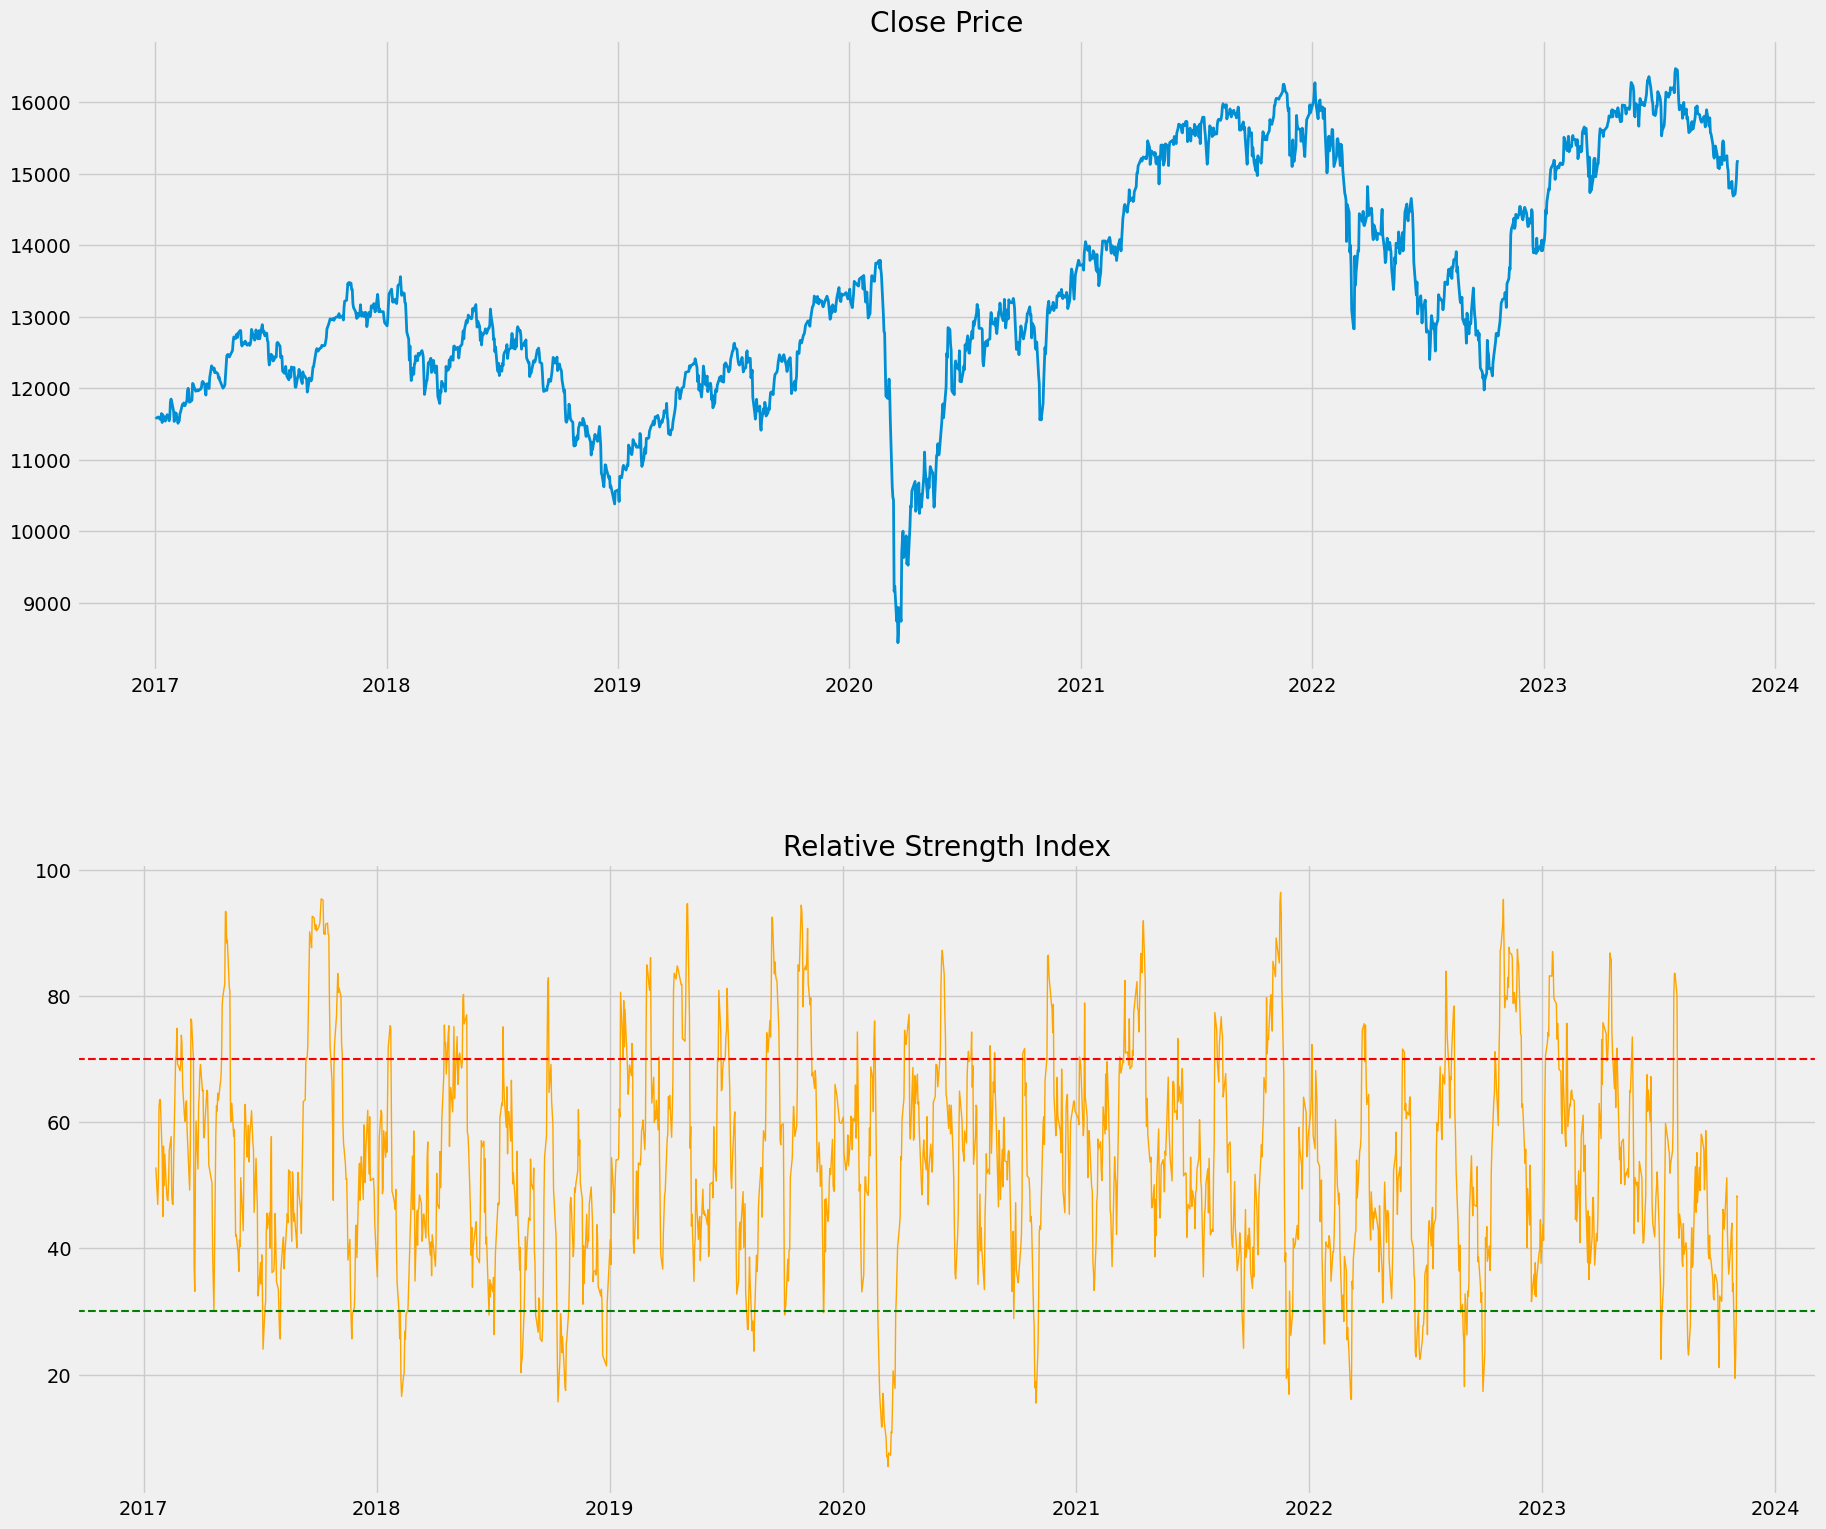

In [39]:
def rsi(df,n):
    change_up = df.copy()
    change_down = df.copy()
    change_up[change_up<0] = 0
    change_down[change_down>0] = 0
    change.equals(change_up+change_down)

    # Calculate the rolling average of average up and average down
    avg_up = change_up.rolling(n).mean()
    avg_down = change_down.rolling(n).mean().abs()
    #if avg_up == 0:
     #   return 0
    #elif avg_down == 0:
     #   return 100
    #else:
    return 100 * avg_up / (avg_up + avg_down)

# Take a look at the 20 oldest datapoints
rsix = rsi(change,14)



# Set the theme of our chart
plt.style.use('fivethirtyeight')

# Make our resulting figure much bigger
plt.rcParams['figure.figsize'] = (20, 20)

# Create two charts on the same figure.
ax1 = plt.subplot2grid((10,1), (0,0), rowspan = 4, colspan = 1)
ax2 = plt.subplot2grid((10,1), (5,0), rowspan = 4, colspan = 1)


# Second chart
# Plot the RSI
ax2.set_title('Relative Strength Index')
ax2.plot(rsix, color='orange', linewidth=1)
# Add two horizontal lines, signalling the buy and sell ranges.
# Oversold
ax2.axhline(30, linestyle='--', linewidth=1.5, color='green')
# Overbought
ax2.axhline(70, linestyle='--', linewidth=1.5, color='red')



# Set the theme of our chart
plt.style.use('fivethirtyeight')

# Make our resulting figure much bigger
plt.rcParams['figure.figsize'] = (20, 20)

# Create two charts on the same figure.
ax1 = plt.subplot2grid((10,1), (0,0), rowspan = 4, colspan = 1)
ax2 = plt.subplot2grid((10,1), (5,0), rowspan = 4, colspan = 1)

# First chart:
# Plot the closing price on the first chart
ax1.plot(data["Adj Close"], linewidth=2)
ax1.set_title('Close Price')

# Second chart
# Plot the RSI
ax2.set_title('Relative Strength Index')
ax2.plot(rsix, color='orange', linewidth=1)
# Add two horizontal lines, signalling the buy and sell ranges.
# Oversold
ax2.axhline(30, linestyle='--', linewidth=1.5, color='green')
# Overbought
ax2.axhline(70, linestyle='--', linewidth=1.5, color='red')

In [45]:
df.loc[df.index[-1],"Volume"]

93603800

In [46]:
df.iloc[len(df)-1]

Open        15203.7998046875
High                 15269.5
Low         15149.7197265625
Close               15189.25
Adj Close           15189.25
Volume            93603800.0
Name: 2023-11-03 00:00:00, dtype: float64

In [63]:
# Get today's date in the required format
today_date = date.today().strftime('%Y-%m-%d')

# Create a new row with today's date and 14256 in all columns
new_row = pd.DataFrame({
    "Date": endDate,
    "Open": [15150],
    "High": [15150],
    "Low": [15110],
    "Close": [15120],
    "Adj Close": [15120],
    "Volume": df.loc[df.index[-1],"Volume"]
})

new_row.set_index('Date', inplace=True)

# Concatenate the new row to the original DataFrame
df = pd.concat([df, new_row])

In [64]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-02 00:00:00.000000,9598.25,9620.9296875,9394.2099609375,9400.0400390625,9400.0400390625,90956900
2014-01-03 00:00:00.000000,9409.66015625,9453.48046875,9367.990234375,9435.150390625,9435.150390625,58772900
2014-01-06 00:00:00.000000,9419.4404296875,9468.7998046875,9399.8095703125,9428.0,9428.0,53653700
2014-01-07 00:00:00.000000,9446.25,9518.7197265625,9416.8603515625,9506.2001953125,9506.2001953125,79946800
2014-01-08 00:00:00.000000,9512.7900390625,9516.259765625,9467.9501953125,9497.83984375,9497.83984375,90140400
...,...,...,...,...,...,...
2023-10-31 00:00:00.000000,14741.4404296875,14829.6201171875,14722.3798828125,14810.33984375,14810.33984375,75370200
2023-11-01 00:00:00.000000,14851.9599609375,14949.580078125,14786.3203125,14923.26953125,14923.26953125,63588700
2023-11-02 00:00:00.000000,15033.650390625,15202.4296875,15028.0302734375,15143.599609375,15143.599609375,89446500


In [65]:
# Clean NaN values
df = dropna(df)

# Add all ta features
df = add_all_ta_features(
    df, open="Open", high="High", low="Low", close="Close", volume="Volume"
)

df.tail()  # Check to make sure

,Open,High,Low,Close,Adj Close,Volume,volume_adi,volume_obv,volume_cmf,volume_fi,...,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr
Date,,,,,,,,,,,,,,,,,,,,,
2023-10-31 00:00:00.000000,14741.4404296875,14829.6201171875,14722.3798828125,14810.33984375,14810.33984375,75370200.0,9517711661.879654,9663049500.0,0.021968734169226976,-2119847171.7231789,...,-1.2789712166197464,-1.1510767313313113,-0.12789448528843517,6.811432045570935,4.351259731802021,2.460172313768914,14907.461134487796,0.637376750503349,0.6353540949675107,57.55613574202487
2023-11-01 00:00:00.000000,14851.9599609375,14949.580078125,14786.3203125,14923.26953125,14923.26953125,63588700.0,9560804761.317379,9726638200.0,0.03494231356004552,-791147287.2582605,...,-1.1714305082648198,-1.1551474867180132,-0.01628302154680661,4.817682439953344,4.444544273432286,0.37313816652105825,14908.02535787612,0.7625057135178137,0.7596133324446086,58.757510279055694
2023-11-02 00:00:00.000000,15033.650390625,15202.4296875,15028.0302734375,15143.599609375,15143.599609375,89446500.0,9589905363.811989,9816084700.0,0.07473265015223733,2137267229.9226067,...,-0.9561251776643723,-1.115343024907285,0.15921784724291277,5.912174960819472,4.738070410909724,1.1741045499097487,14911.627978963941,1.4764196120938378,1.465626641081741,61.10143729648758
2023-11-03 00:00:00.000000,15203.7998046875,15269.5,15149.7197265625,15189.25,15189.25,93603800.0,9558084421.750109,9909688500.0,0.006306335276688084,2442379059.0742884,...,-0.7523010641054984,-1.0427346327469278,0.29043356864142944,7.076215929801655,5.20569951468811,1.8705164151135447,14947.315444614662,0.30145006340989156,0.3009966137605957,61.58707768137208
2023-11-06 18:05:40.371375,15150.0,15150.0,15110.0,15120.0,15120.0,93603800.0,9511282521.750109,9816084700.0,-0.018966019111925587,1167458743.4922476,...,-0.6209456390356599,-0.9583768340046742,0.3374311949690143,7.854255517791935,5.735410715308875,2.1188448024830597,14961.458298314757,-0.45591454482610816,-0.456957004878511,60.85037869166323


In [66]:
# Add all ta features
data_ndx = dropna(data_ndx)
data_ndx = add_all_ta_features(
    data_ndx, open="Open", high="High", low="Low", close="Close", volume="Volume"
)


## ADX

In [67]:
from ta.utils import IndicatorMixin, _ema, _get_min_max


class ADXIndicator(IndicatorMixin):
    """Average Directional Movement Index (ADX)
    The Plus Directional Indicator (+DI) and Minus Directional Indicator (-DI)
    are derived from smoothed averages of these differences, and measure trend
    direction over time. These two indicators are often referred to
    collectively as the Directional Movement Indicator (DMI).
    The Average Directional Index (ADX) is in turn derived from the smoothed
    averages of the difference between +DI and -DI, and measures the strength
    of the trend (regardless of direction) over time.
    Using these three indicators together, chartists can determine both the
    direction and strength of the trend.
    http://stockcharts.com/school/doku.php?id=chart_school:technical_indicators:average_directional_index_adx
    Args:
        high(pandas.Series): dataset 'High' column.
        low(pandas.Series): dataset 'Low' column.
        close(pandas.Series): dataset 'Close' column.
        window(int): n period.
        fillna(bool): if True, fill nan values.
    """

    def __init__(
        self,
        high: pd.Series,
        low: pd.Series,
        close: pd.Series,
        window: int = 14,
        fillna: bool = False,
    ):
        self._high = high
        self._low = low
        self._close = close
        self._window = window
        self._fillna = fillna
        self._run()

    def _run(self):
        if self._window == 0:
            raise ValueError("window may not be 0")

        close_shift = self._close.shift(1)
        pdm = _get_min_max(self._high, close_shift, "max")
        pdn = _get_min_max(self._low, close_shift, "min")
        diff_directional_movement = pdm - pdn

        self._trs_initial = np.zeros(self._window - 1)
        self._trs = np.zeros(len(self._close) - (self._window - 1))
        self._trs[0] = diff_directional_movement.dropna()[
            0 : self._window  # noqa E203
        ].sum()  # noqa E203
        diff_directional_movement = diff_directional_movement.reset_index(drop=True)

        for i in range(1, len(self._trs) - 1):
            self._trs[i] = (
                self._trs[i - 1]
                - (self._trs[i - 1] / float(self._window))
                + diff_directional_movement[self._window + i]
            )

        diff_up = self._high - self._high.shift(1)
        diff_down = self._low.shift(1) - self._low
        pos = abs(((diff_up > diff_down) & (diff_up > 0)) * diff_up)
        neg = abs(((diff_down > diff_up) & (diff_down > 0)) * diff_down)

        self._dip = np.zeros(len(self._close) - (self._window - 1))
        self._dip[0] = pos.dropna()[0 : self._window].sum()  # noqa E203

        pos = pos.reset_index(drop=True)

        for i in range(1, len(self._dip) - 1):
            self._dip[i] = (
                self._dip[i - 1]
                - (self._dip[i - 1] / float(self._window))
                + pos[self._window + i]
            )

        self._din = np.zeros(len(self._close) - (self._window - 1))
        self._din[0] = neg.dropna()[0 : self._window].sum()  # noqa E203

        neg = neg.reset_index(drop=True)

        for i in range(1, len(self._din) - 1):
            self._din[i] = (
                self._din[i - 1]
                - (self._din[i - 1] / float(self._window))
                + neg[self._window + i]
            )

    def adx(self) -> pd.Series:
        """Average Directional Index (ADX)
        Returns:
            pandas.Series: New feature generated.tr
        """
        dip = np.zeros(len(self._trs))

        for idx, value in enumerate(self._trs):
            dip[idx] = 100 * (self._dip[idx] / value)

        din = np.zeros(len(self._trs))

        for idx, value in enumerate(self._trs):
            din[idx] = 100 * (self._din[idx] / value)

        directional_index = 100 * np.abs((dip - din) / (dip + din))

        adx_series = np.zeros(len(self._trs))
        adx_series[self._window] = directional_index[
            0 : self._window  # noqa E203
        ].mean()

        for i in range(self._window + 1, len(adx_series)):
            adx_series[i] = (
                (adx_series[i - 1] * (self._window - 1)) + directional_index[i - 1]
            ) / float(self._window)

        adx_series = np.concatenate((self._trs_initial, adx_series), axis=0)
        adx_series = pd.Series(data=adx_series, index=self._close.index)

        adx_series = self._check_fillna(adx_series, value=20)
        return pd.Series(adx_series, name="adx")

    def adx_pos(self) -> pd.Series:
        """Plus Directional Indicator (+DI)
        Returns:
            pandas.Series: New feature generated.
        """
        dip = np.zeros(len(self._close))
        for i in range(1, len(self._trs) - 1):
            dip[i + self._window] = 100 * (self._dip[i] / self._trs[i])

        adx_pos_series = self._check_fillna(
            pd.Series(dip, index=self._close.index), value=20
        )
        return pd.Series(adx_pos_series, name="adx_pos")

    def adx_neg(self) -> pd.Series:
        """Minus Directional Indicator (-DI)
        Returns:
            pandas.Series: New feature generated.
        """
        din = np.zeros(len(self._close))
        for i in range(1, len(self._trs) - 1):
            din[i + self._window] = 100 * (self._din[i] / self._trs[i])

        adx_neg_series = self._check_fillna(
            pd.Series(din, index=self._close.index), value=20
        )
        return pd.Series(adx_neg_series, name="adx_neg")

In [68]:
today_date = datetime.now().strftime('%Y-%m-%d')

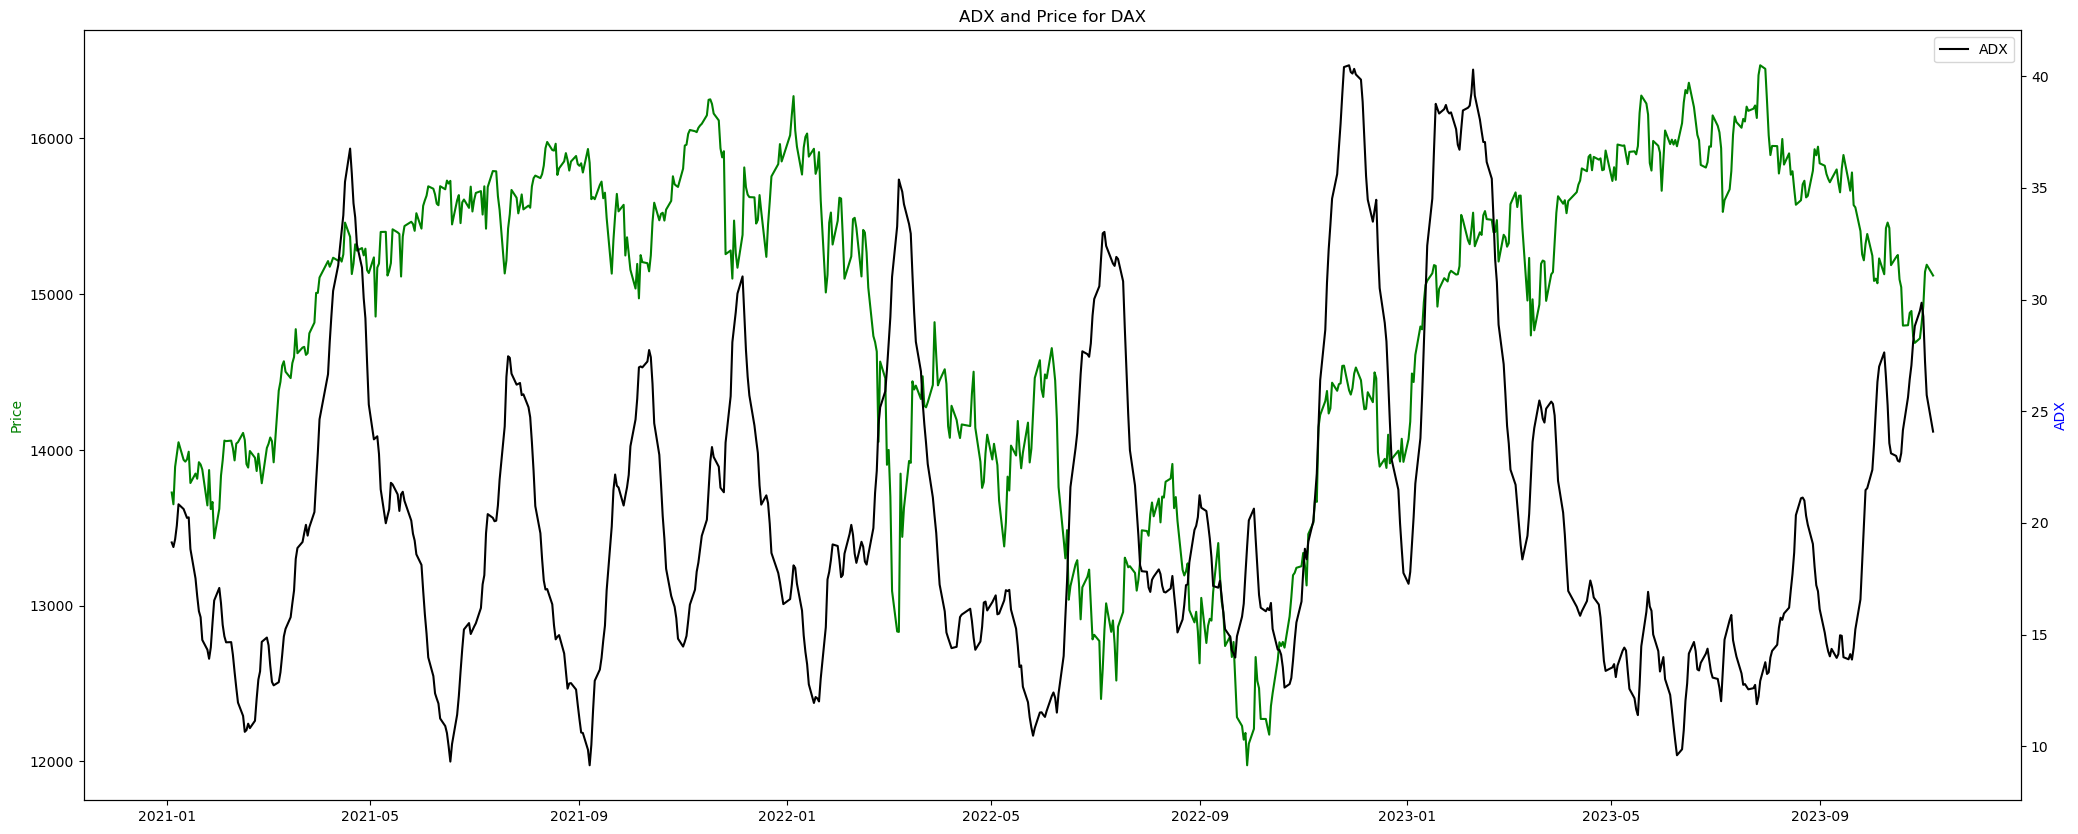

In [69]:
fig, ax1 = plt.subplots(figsize=(25, 10))
ax2 = ax1.twinx()
ax1.plot(df['2021-01-01':today_date].Close, "g-", label="Close")
#ax2.plot(df['2021-01-01':today_date].trend_adx_pos, 'b-', label='ADX Pos')
#ax2.plot(df['2021-01-01':today_date].trend_adx_neg, 'r-', label='ADX Neg' )
ax2.plot(df['2021-01-01':today_date].trend_adx, "k-", label="ADX")

ax1.set_ylabel("Price", color="g")
ax2.set_ylabel("ADX", color="b")

plt.title("ADX and Price for DAX", color="k")
plt.legend()
plt.show()

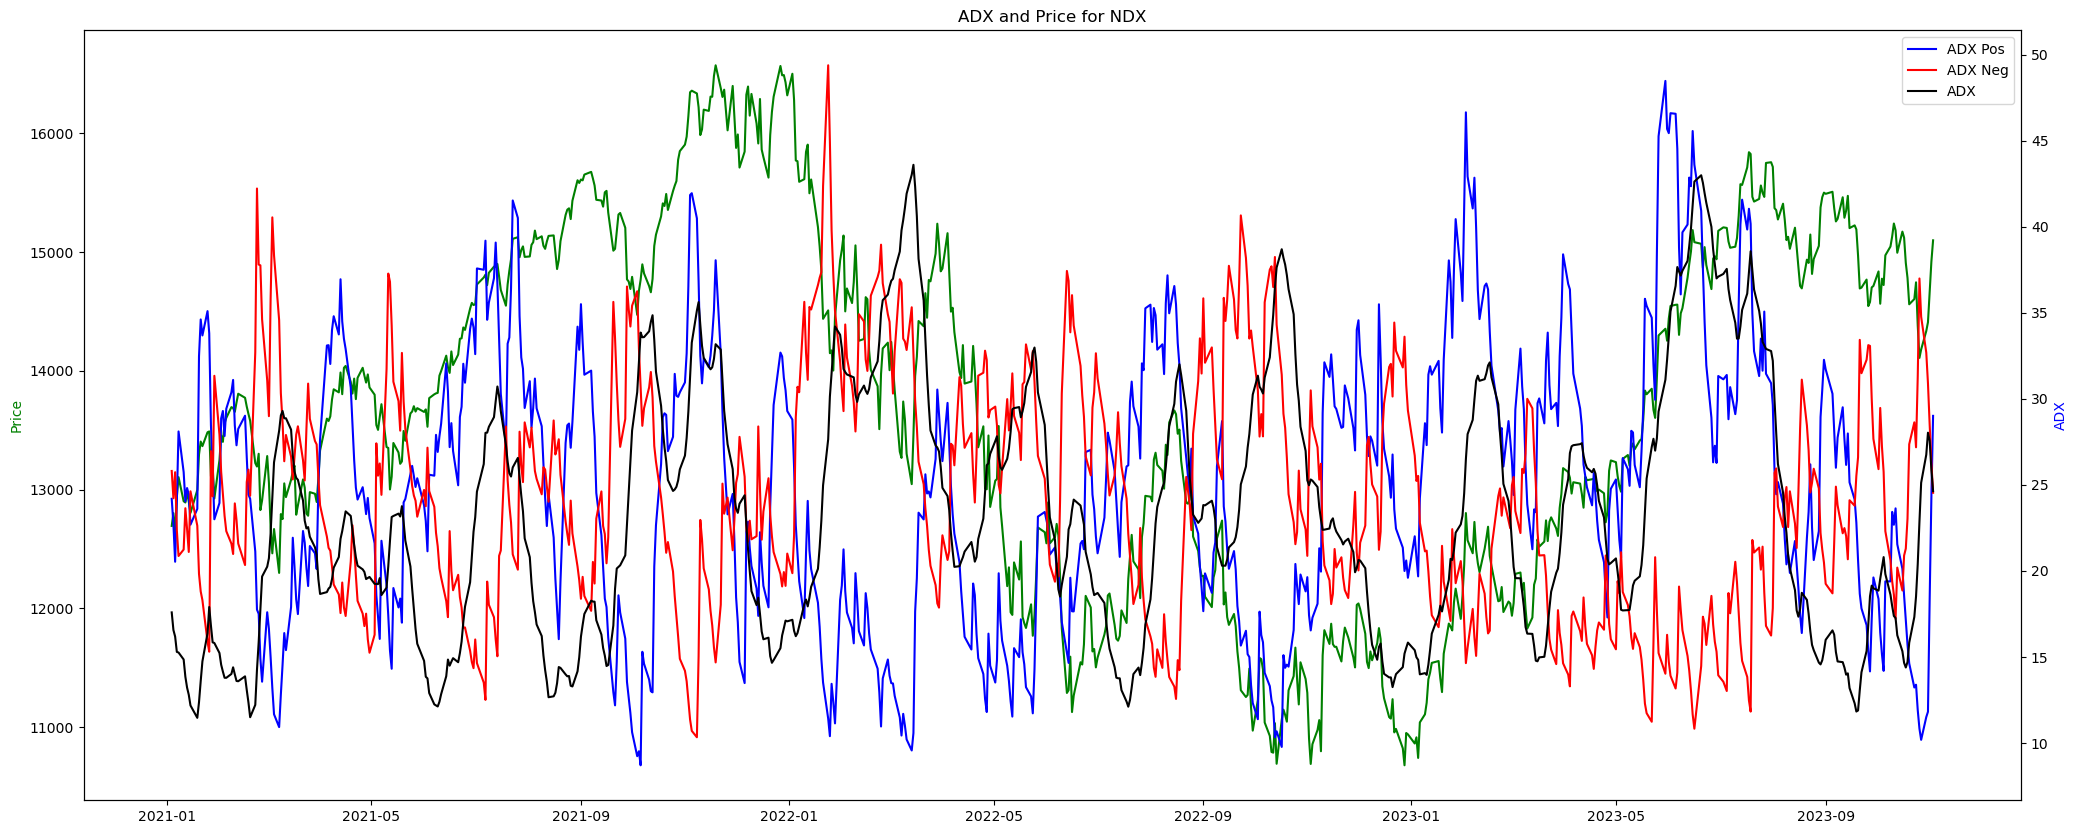

In [70]:
fig, ax1 = plt.subplots(figsize=(25, 10))
ax2 = ax1.twinx()
ax1.plot(data_ndx['2021-01-01':today_date].Close, "g-", label="Close")
ax2.plot(data_ndx['2021-01-01':today_date].trend_adx_pos, 'b-', label='ADX Pos')
ax2.plot(data_ndx['2021-01-01':today_date].trend_adx_neg, 'r-', label='ADX Neg' )
ax2.plot(data_ndx['2021-01-01':today_date].trend_adx, "k-", label="ADX")

ax1.set_ylabel("Price", color="g")
ax2.set_ylabel("ADX", color="b")

plt.title("ADX and Price for NDX", color="k")
plt.legend()
plt.show()

## MACD

In [71]:
class MACD(IndicatorMixin):
    """Moving Average Convergence Divergence (MACD)
    Is a trend-following momentum indicator that shows the relationship between
    two moving averages of prices.
    Args:
        close(pandas.Series): dataset 'Close' column.
        window_fast(int): n period short-term.
        window_slow(int): n period long-term.
        window_sign(int): n period to signal.
        fillna(bool): if True, fill nan values.
    """

    def __init__(
        self,
        close: pd.Series,
        window_slow: int = 26,
        window_fast: int = 12,
        window_sign: int = 9,
        fillna: bool = False,
    ):
        self._close = close
        self._window_slow = window_slow
        self._window_fast = window_fast
        self._window_sign = window_sign
        self._fillna = fillna
        self._run()

    def _run(self):
        self._emafast = _ema(self._close, self._window_fast, self._fillna)
        self._emaslow = _ema(self._close, self._window_slow, self._fillna)
        self._macd = self._emafast - self._emaslow
        self._macd_signal = _ema(self._macd, self._window_sign, self._fillna)
        self._macd_diff = self._macd - self._macd_signal

    def macd(self) -> pd.Series:
        """MACD Line
        Returns:
            pandas.Series: New feature generated.
        """
        macd_series = self._check_fillna(self._macd, value=0)
        return pd.Series(
            macd_series, name=f"MACD_{self._window_fast}_{self._window_slow}"
        )

    def macd_signal(self) -> pd.Series:
        """Signal Line
        Returns:
            pandas.Series: New feature generated.
        """

        macd_signal_series = self._check_fillna(self._macd_signal, value=0)
        return pd.Series(
            macd_signal_series,
            name=f"MACD_sign_{self._window_fast}_{self._window_slow}",
        )

    def macd_diff(self) -> pd.Series:
        """MACD Histogram
        Returns:
            pandas.Series: New feature generated.
        """
        macd_diff_series = self._check_fillna(self._macd_diff, value=0)
        return pd.Series(
            macd_diff_series, name=f"MACD_diff_{self._window_fast}_{self._window_slow}"
        )

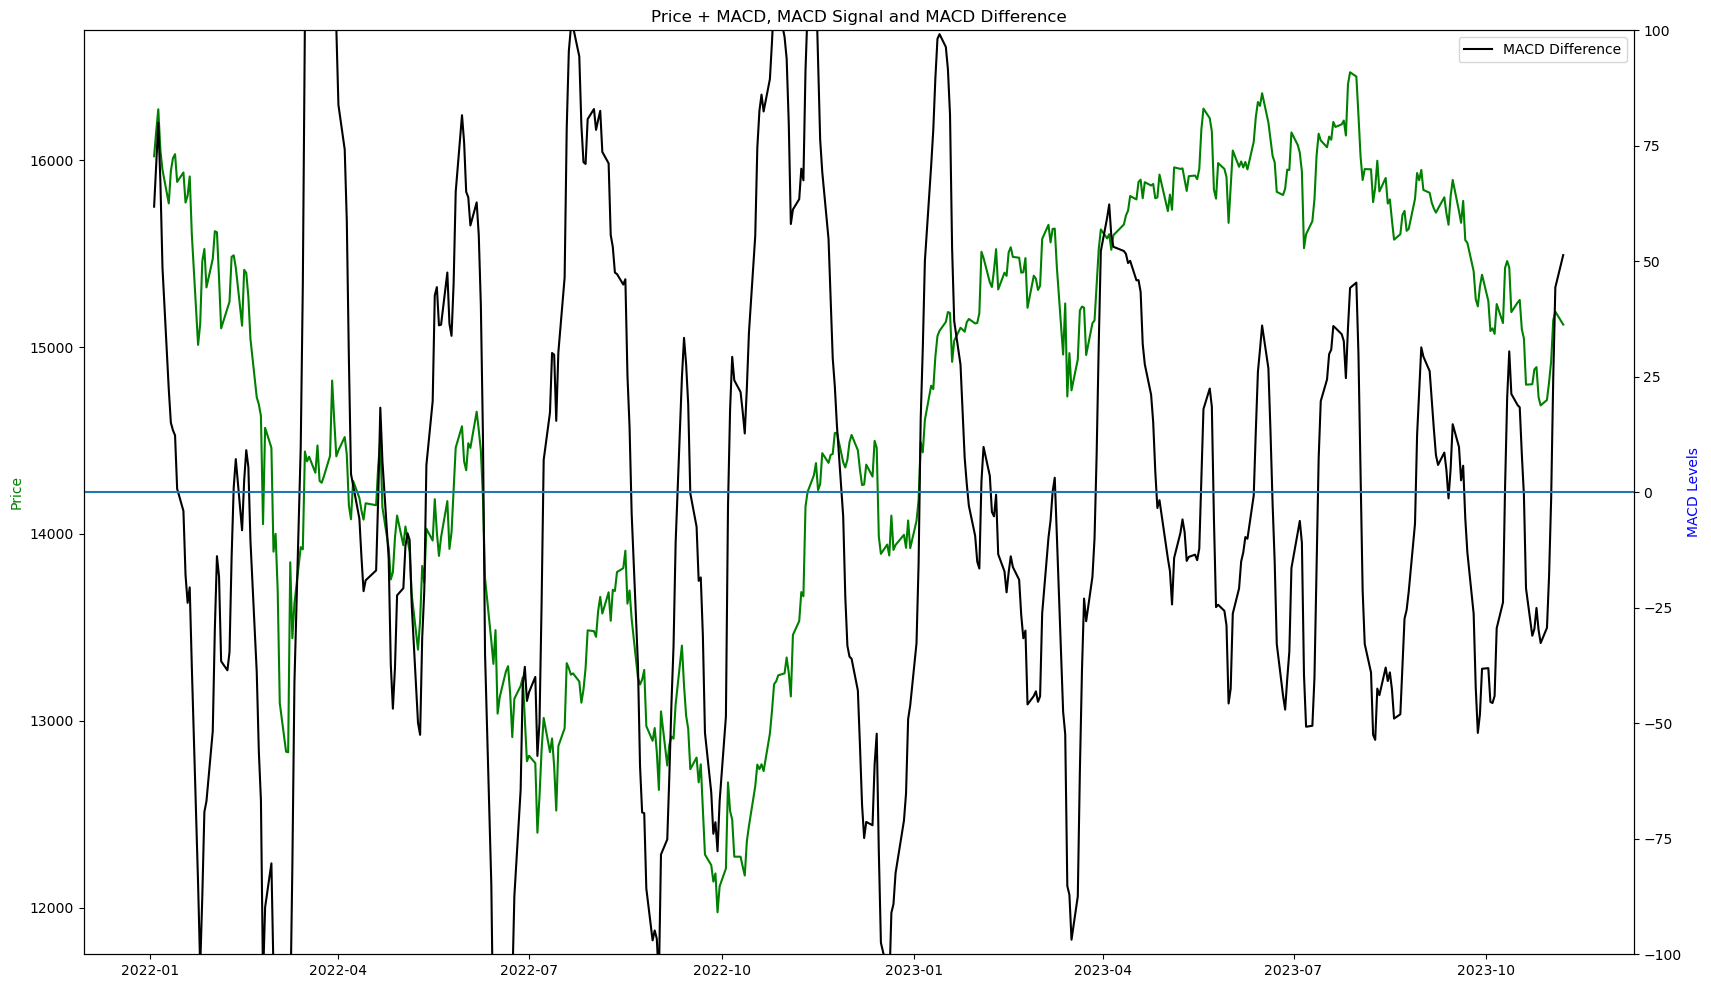

In [72]:
fig, ax1 = plt.subplots(figsize=(20, 12))
ax2 = ax1.twinx()
ax1.plot(df['2022-01-01':today_date].Close, "g-", label="Close")
# ax2.plot(df[40640:42000].trend_macd, 'b-', label='MACD')
# ax2.plot(df[40640:42000].trend_macd_signal, 'r-', label='MACD Signal' )
ax2.plot(df['2022-01-01':today_date].trend_macd_diff, "k-", label="MACD Difference")

ax1.set_ylabel("Price", color="g")
ax2.set_ylabel("MACD Levels", color="b")

ax2.set_ylim(-100, 100)
ax2.axhline(0)

#plt.ylim([8000, 18000])
plt.title("Price + MACD, MACD Signal and MACD Difference", color="k")
plt.legend()
plt.show()

# Fundamental and Sentiment Analysis

In [34]:
from financetoolkit import Toolkit

companies = Toolkit(['DDOG'], api_key="E3yXSPEhmarwcSabzWQGo4ticCTbe0Ym", start_date='2018-01-31')

# a Historical example
historical_data = companies.get_historical_data()


# a Financial Statement example
balance_sheet_statement = companies.get_balance_sheet_statement()

# a Ratios example
profitability_ratios = companies.ratios.collect_profitability_ratios()

# a Models example
extended_dupont_analysis = companies.models.get_extended_dupont_analysis()

# a Performance example
capital_asset_pricing_model = companies.performance.get_capital_asset_pricing_model(show_full_results=True)

# a Risk example
value_at_risk = companies.risk.get_value_at_risk(period='quarterly')

# a Technical example
bollinger_bands = companies.technicals.get_bollinger_bands()


Obtaining cashflow data: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.72it/s]


The following data was not provided within the Toolkit class and thus was retrieved from FinancialModelingPrep: Income Statement, Cash Flow Statement.


In [35]:
balance_sheet_statement

date,2018,2019,2020,2021,2022
Cash and Cash Equivalents,53639000.0,597297000.0,224927000.0,270973000.0,338985000.0
Short Term Investments,0.0,176674000.0,1292532000.0,1283473000.0,1545341000.0
Cash and Short Term Investments,53639000.0,773971000.0,1517459000.0,1554446000.0,1884326000.0
Accounts Receivable,56348000.0,102394000.0,163359000.0,268824000.0,399551000.0
Inventory,0.0,0.0,0.0,0.0,33054000.0
Other Current Assets,11964000.0,27577000.0,37262000.0,47678000.0,27303000.0
Total Current Assets,121951000.0,903942000.0,1718080000.0,1870948000.0,2344234000.0
"Property, Plant and Equipment",21649000.0,85751000.0,105026000.0,136507000.0,212975000.0
Goodwill,7626000.0,9058000.0,17609000.0,292176000.0,348277000.0
Intangible Assets,1288000.0,1435000.0,2069000.0,15704000.0,16365000.0


In [36]:
balance_sheet_statement_transposed = balance_sheet_statement.transpose()

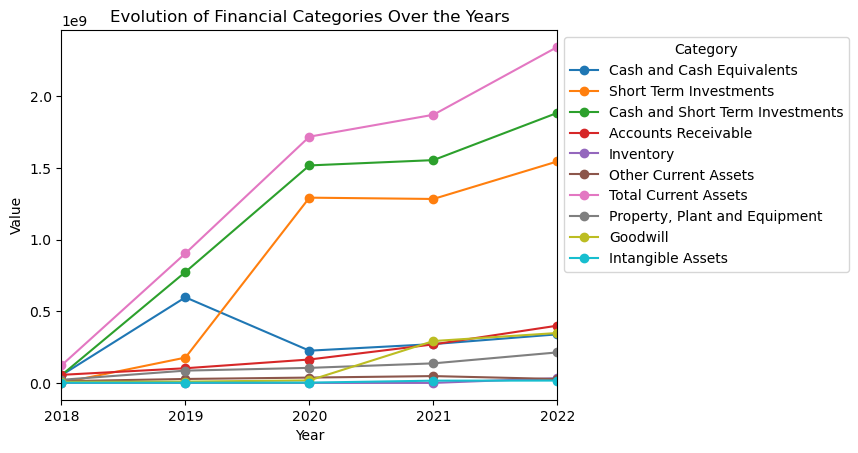

In [37]:
columns_to_plot = [
    'Cash and Cash Equivalents',
    'Short Term Investments',
    'Cash and Short Term Investments',
    'Accounts Receivable',
    'Inventory',
    'Other Current Assets',
    'Total Current Assets',
    'Property, Plant and Equipment',
    'Goodwill',
    'Intangible Assets'
]

# Plot the selected columns
balance_sheet_statement_transposed[columns_to_plot].plot(marker='o')
plt.title('Evolution of Financial Categories Over the Years')
plt.xlabel('Year')
plt.ylabel('Value')
plt.legend(title='Category', loc='upper left', bbox_to_anchor=(1, 1))

# Show the plot
plt.show()

In [38]:
profitability_ratios

date,2018,2019,2020,2021,2022
Gross Margin,0.7651,0.7548,0.7843,0.7723,0.793
Operating Margin,-0.0557,-0.0555,0.0136,0.0026,-0.0149
Net Profit Margin,-0.0543,-0.0461,-0.0407,-0.0202,-0.0299
Interest Coverage Ratio,-inf,-inf,0.7775,1.2145,0.7386
Income Before Tax Profit Margin,-0.0517,-0.044,-0.0368,-0.0179,-0.0227
Effective Tax Rate,-0.051,-0.0459,-0.1046,-0.1261,-0.3176
Return on Assets (ROA),NaN,-0.0274,-0.0168,-0.0097,-0.0186
Return on Equity (ROE),NaN,-0.0473,-0.0282,-0.0208,-0.0409
Return on Invested Capital (ROIC),NaN,-0.0456,-0.0222,-0.0135,-0.0297
Return on Capital Employed (ROCE),-0.1517,-0.0191,0.0052,0.0014,-0.0111


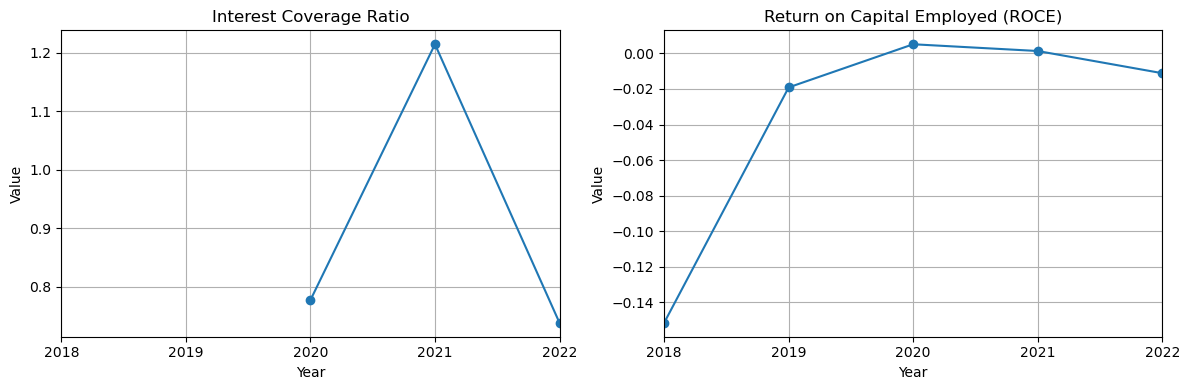

In [39]:
rows_to_plot = profitability_ratios.loc[['Interest Coverage Ratio', 'Return on Capital Employed (ROCE)']]
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

rows_to_plot.iloc[0].plot(ax=axes[0], marker='o')
axes[0].set_title('Interest Coverage Ratio')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Value')
axes[0].grid()

rows_to_plot.iloc[1].plot(ax=axes[1], marker='o')
axes[1].set_title('Return on Capital Employed (ROCE)')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Value')
axes[1].grid()
plt.tight_layout()
plt.show()

In [40]:
capital_asset_pricing_model

,Risk Free Rate,Beta DDOG,Benchmark Returns,CAPM DDOG
Date,,,,
2018,0.0269,NaN,-0.0624,NaN
2019,0.0192,1.6059,0.2888,0.4521
2020,0.0092,0.7478,0.1626,0.1239
2021,0.0151,1.6502,0.2689,0.4339
2022,0.0388,2.0841,-0.1944,-0.4472
2023,0.0464,1.8859,0.1349,0.2133


In [41]:
value_at_risk

,DDOG,Benchmark
2017Q1,NaN,NaN
2017Q2,NaN,-0.0068
2017Q3,NaN,-0.0072
2017Q4,NaN,-0.0041
2018Q1,NaN,-0.0212
2018Q2,NaN,-0.0131
2018Q3,NaN,-0.0065
2018Q4,NaN,-0.0267
2019Q1,NaN,-0.0094
2019Q2,NaN,-0.0117


In [10]:
from nrclex import NRCLex

In [7]:
text = '''
RBC Capital downgraded shares of ResMed (NYSE:RMD) to Sector Perform from Outperform in a note Thursday, lowering the price target to $202 from $273 per share.

RBC analysts told investors in a note that the long-term valuation appeals, but the company's minimal EPS growth will limit a near-term re-rating.

"We expect GLP-1 drugs to have only a modest impact on RMD's business, and therefore believe the stock offers long-term valuation appeal," they explained.

"However, our recent channel checks suggest the re-PAP backlog has now been largely addressed, which means RMD's device revenues are most likely to decline between FY24-FY26 as Philips re-enters the new-patient market."

In addition, the analysts said their firm believes RMD's financials are likely to disappoint consensus numbers, while GLP-1 fears are unlikely to be countered in the short term.
'''

In [9]:
print(text)


RBC Capital downgraded shares of ResMed (NYSE:RMD) to Sector Perform from Outperform in a note Thursday, lowering the price target to $202 from $273 per share.

RBC analysts told investors in a note that the long-term valuation appeals, but the company's minimal EPS growth will limit a near-term re-rating.

"We expect GLP-1 drugs to have only a modest impact on RMD's business, and therefore believe the stock offers long-term valuation appeal," they explained.

"However, our recent channel checks suggest the re-PAP backlog has now been largely addressed, which means RMD's device revenues are most likely to decline between FY24-FY26 as Philips re-enters the new-patient market."

In addition, the analysts said their firm believes RMD's financials are likely to disappoint consensus numbers, while GLP-1 fears are unlikely to be countered in the short term.



In [16]:
text_object = NRCLex(text)

In [21]:
text_object.words

['RBC',
 'Capital',
 'downgraded',
 'shares',
 'of',
 'ResMed',
 'NYSE',
 'RMD',
 'to',
 'Sector',
 'Perform',
 'from',
 'Outperform',
 'in',
 'a',
 'note',
 'Thursday',
 'lowering',
 'the',
 'price',
 'target',
 'to',
 '202',
 'from',
 '273',
 'per',
 'share',
 'RBC',
 'analysts',
 'told',
 'investors',
 'in',
 'a',
 'note',
 'that',
 'the',
 'long-term',
 'valuation',
 'appeals',
 'but',
 'the',
 'company',
 "'s",
 'minimal',
 'EPS',
 'growth',
 'will',
 'limit',
 'a',
 'near-term',
 're-rating',
 'We',
 'expect',
 'GLP-1',
 'drugs',
 'to',
 'have',
 'only',
 'a',
 'modest',
 'impact',
 'on',
 'RMD',
 "'s",
 'business',
 'and',
 'therefore',
 'believe',
 'the',
 'stock',
 'offers',
 'long-term',
 'valuation',
 'appeal',
 'they',
 'explained',
 'However',
 'our',
 'recent',
 'channel',
 'checks',
 'suggest',
 'the',
 're-PAP',
 'backlog',
 'has',
 'now',
 'been',
 'largely',
 'addressed',
 'which',
 'means',
 'RMD',
 "'s",
 'device',
 'revenues',
 'are',
 'most',
 'likely',
 'to',
 'd

In [17]:
text_object.raw_emotion_scores

{'negative': 3,
 'anticipation': 3,
 'joy': 1,
 'positive': 5,
 'trust': 4,
 'surprise': 1,
 'anger': 1,
 'disgust': 1,
 'sadness': 1}

In [18]:
text_object.top_emotions

[('positive', 0.25)]

In [20]:
text_object.affect_frequencies

{'fear': 0.0,
 'anger': 0.05,
 'anticip': 0.0,
 'trust': 0.2,
 'surprise': 0.05,
 'positive': 0.25,
 'negative': 0.15,
 'sadness': 0.05,
 'disgust': 0.05,
 'joy': 0.05,
 'anticipation': 0.15}

In [23]:
from urllib.parse import urlparse 
parsedUrl = urlparse('https://www.investing.com/') 
print(parsedUrl) 

ParseResult(scheme='https', netloc='www.investing.com', path='/', params='', query='', fragment='')


In [32]:
import urllib.request 
request_url = urllib.request.urlopen('https://www.standard.co.uk/news/world/argentina-election-sergio-massa-run-off-vote-far-right-javier-milei-b1115246.html') 
print(request_url.read())

b'<!DOCTYPE html>\n  <html lang="en">\n    <head>\n      <title >Argentina election: Economy minister Sergio Massa faces run-off vote with far-right candidate Javier Milei | Evening Standard</title>\n      <meta  charset="utf-8"/><meta  name="theme-color" content="#FFFFFF"/><meta  name="viewport" content="width=device-width,minimum-scale=1,initial-scale=1"/><meta  name="robots" content="max-image-preview:large,max-video-preview:-1"/><meta  property="fb:app_id" content="193840110715213"/><meta  property="fb:pages" content="165348596842143"/><meta  name="category" content="World"/><meta  name="sitename" content="Evening Standard"/><meta  name="page path" content="/news/world"/><meta  name="page type" content="Article"/><meta  name="adPageType" content="Article Page"/><meta  property="og:locale" content="en_GB"/><meta  property="og:site_name" content="Evening Standard"/><meta  name="description" content="Far-right candidate places second in Argentinian elections despite polling prediction

## Insider Trades

In [40]:
#Checks volume of insider trades 

In [108]:
import locale

In [113]:
file_path = r'C:\Users\david\OpenBBUserData\exports\openbb_Insider_Data_20230629_094011.xlsx'

In [114]:
df = pd.read_excel(file_path)

In [115]:
df.head()

,X,Filing Date,Trade Date,Ticker,Company Name,Insider Name,Title,Trade Type,Price,Qty,Owned,Diff Own,Value
0,DM,2023-06-28\n21:46:28,2023-06-26,AMC,"Amc Entertainment Holdings, Inc.",Antara Capital LP,10%,S - Sale+OE,$1.79,-5944917,101905306,-6%,"-$10,641,040"
1,M,2023-06-28\n21:35:43,2023-06-26,CYT,"Cyteir Therapeutics, Inc.",Novo Holdings A/s,10%,S - Sale,$1.78,-40415,3863573,-1%,"-$71,794"
2,M,2023-06-28\n21:07:41,2023-06-26,DKL,"Delek Logistics Partners, LP",Yemin Ezra Uzi,Exec COB,S - Sale,$56.16,-10964,219716,-5%,"-$615,772"
3,-,2023-06-28\n21:02:34,2023-06-26,CMTL,Comtech Telecommunications Corp /de/,Carpenter Wendi B.,Dir,P - Purchase,$9.60,1000,4506,+29%,"+$9,600"
4,-,2023-06-28\n21:00:23,2023-06-27,RH,Rh,Demilio Mark S,Dir,S - Sale,$305.24,-2000,34416,-5%,"-$610,473"


In [116]:
df['Value'] = df['Value'].astype(str).str.replace('[$,]', '', regex=True).astype(float)

    # Sum the values in the 'Value' column
total_value = df['Value'].sum()

    # Set the locale to format numbers with thousands separators
locale.setlocale(locale.LC_ALL, '')

    # Format the total value with thousands separators
formatted_total_value = locale.format_string("%.2f", total_value, grouping=True)

print(f"Sum of 'Value' column: ${formatted_total_value}")

Sum of 'Value' column: $-1 336 938 045,00
